# Import Libraries

In [1]:
!pip install pyarrow kneed contractions sentence_transformers umap-learn langdetect testfixtures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
import statsmodels.api as sm

import datetime
import re
import requests
import string
import time
import contractions
from functools import reduce

import umap.umap_ as umap
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from textblob import TextBlob, Word
from typing import List, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from langdetect import detect
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm, trange
from sklearn import utils
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Load Dataset

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
df_raw = pd.read_parquet('./drive/MyDrive/IS4242/datasets/smartlocal_raw.parquet')
df_raw.head()

url  \
0  https://thesmartlocal.com/read/kampong-gelam-b...   
1        https://thesmartlocal.com/read/headrock-vr/   
2   https://thesmartlocal.com/read/free-steam-games/   
3  https://thesmartlocal.com/read/marina-south-pier/   
4  https://thesmartlocal.com/read/tayo-station-si...   

                                               title            subcategory  \
0  Kampong Gelam Bazaar 2023 Has Light Projection...             Activities   
1  HeadRock VR: Virtual Reality Theme Park At Sen...            Attractions   
2  30 Free Steam Games To Add To Your Library Fro...                 Gaming   
3  Marina South Pier: Ferry Rides To The Southern...             Activities   
4  Tayo Station Is A Massive Indoor Playground Wi...  Family & Kid-friendly   

                                             preview  \
0  There’s an elevated mezzanine seating area wit...   
1  The hyper-realistic virtual skyscraper game se...   
2  Thankfully, not all great games require a port...   
3  If you’re looking for an outdoor adventure bey...   
4  Fans of Tayo The Little Bus, right this way pl...   

                                             content reading_duration  \
0  Follow us on Telegram for the latest updates: ...                4   
1  Follow us on Telegram for the latest updates: ...                3   
2  Follow us on Telegram for the latest updates: ...               18   
3  Follow us on Telegram for the latest updates: ...                3   
4  Follow us on Telegram for the latest updates: ...                3   

            author publish_date  num_imgs  num_hrefs  num_self_hrefs  \
0   Dewi Nurjuwita   2023-03-21         8         10              10   
1      Renae Cheng   2023-03-21         9          8               8   
2       Billy Tran   2023-03-21        32        117             117   
3       Megan Khoe   2023-03-21         5         24              24   
4  Samantha Nguyen   2023-03-21         7         12              12   

   num_tags  num_shares  
0         1           1  
1         2           1  
2         2        1650  
3         6        1441  
4         4          63

# Initial EDA on raw data

In [ ]:
# check for missing values
df_raw.isnull().sum()

url                 0
title               0
subcategory         0
preview             0
content             0
reading_duration    0
author              0
publish_date        0
num_imgs            0
num_hrefs           0
num_self_hrefs      0
num_tags            0
num_shares          0
dtype: int64

In [ ]:
df_raw.dtypes

url                         object
title                       object
subcategory                 object
preview                     object
content                     object
reading_duration            object
author                      object
publish_date        datetime64[ns]
num_imgs                     int64
num_hrefs                    int64
num_self_hrefs               int64
num_tags                     int64
num_shares                   int64
dtype: object

In [ ]:
# change reading duration to int
df_raw['reading_duration'].value_counts()

6                          605
7                          554
4                          510
5                          504
3                          491
8                          464
9                          331
2                          264
10                         206
11                         146
12                          99
13                          76
14                          37
15                          22
16                          14
18                          12
17                          11
20                           7
1                            7
19                           5
24                           3
23                           2
4 minutes reading time       2
5 minutes reading time       2
22                           1
2 minutes reading time       1
9 min read                   1
6 minutes reading time       1
10 minutes reading time      1
featured                     1
28                           1
35                           1
21      

In [ ]:
# drop row with 'featured' value
df_raw = df_raw[df_raw['reading_duration']!='featured'].copy()
# remove words and change to int
df_raw['reading_duration'] = df_raw['reading_duration'].apply(lambda x: int(x.split()[0])).copy()

In [ ]:
df_raw.shape

(4389, 13)

In [ ]:
df_raw.describe()

reading_duration     num_imgs    num_hrefs  num_self_hrefs  \
count       4389.000000  4389.000000  4389.000000     4389.000000   
mean           6.579403    13.228982    19.498975       19.498975   
std            3.559546     9.595949    19.313581       19.313581   
min            1.000000     0.000000     0.000000        0.000000   
25%            4.000000     7.000000     7.000000        7.000000   
50%            6.000000    11.000000    14.000000       14.000000   
75%            8.000000    16.000000    27.000000       27.000000   
max           73.000000   166.000000   380.000000      380.000000   

          num_tags    num_shares  
count  4389.000000   4389.000000  
mean      2.905218    642.614719  
std       1.993641   1572.699562  
min       0.000000      0.000000  
25%       2.000000     70.000000  
50%       3.000000    189.000000  
75%       4.000000    518.000000  
max      17.000000  31131.000000

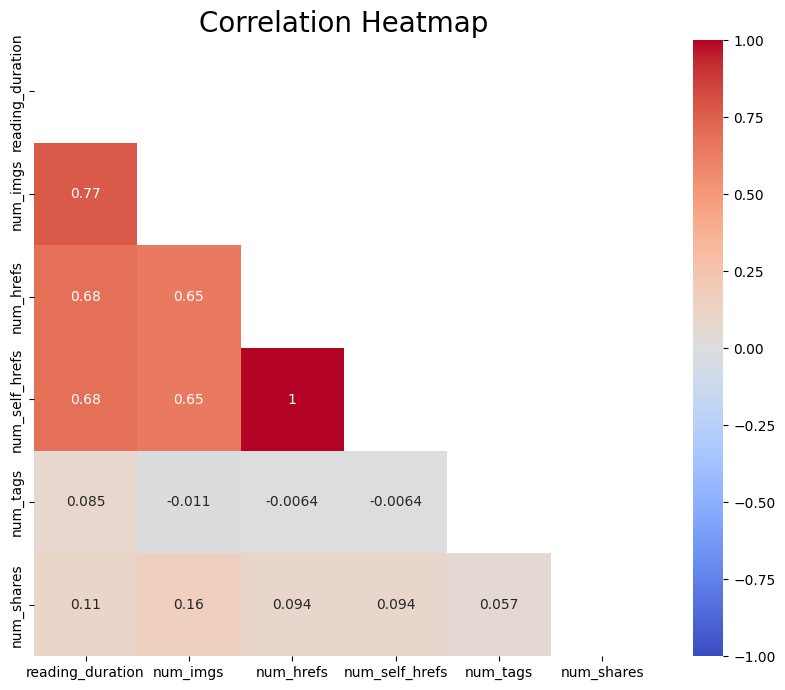

In [ ]:
corr_mat = df_raw.corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm', mask = mask, vmin=-1, vmax=1, )
plt.title('Correlation Heatmap', fontsize = 20)
plt.show()

Given that num_hrefs and num_self_hrefs are perfectly correlated, **we will drop one of them (num_self_href)** moving forward.

In [ ]:
df_raw.drop(columns="num_self_hrefs", inplace=True)

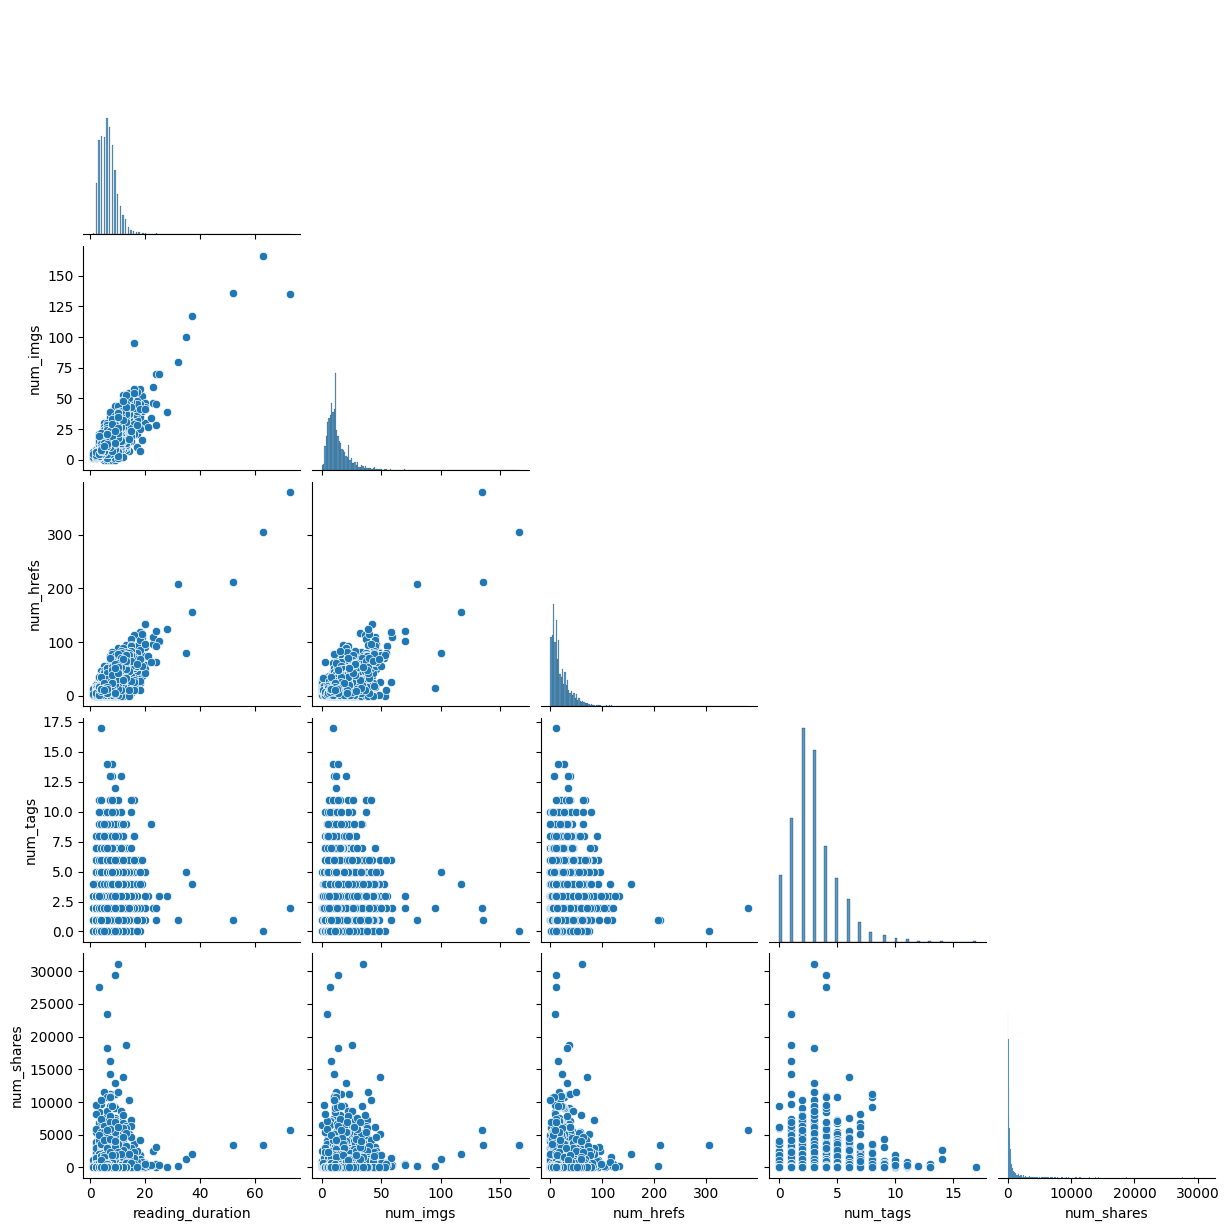

In [ ]:
pairplot = sns.pairplot(df_raw, corner=True)
plt.show(pairplot)

Let's look at the distribution of our Target Variable (Number of Shares)

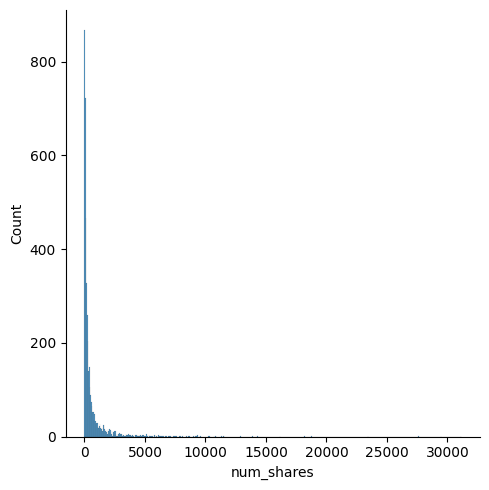

In [ ]:
sns.displot(df_raw['num_shares'])

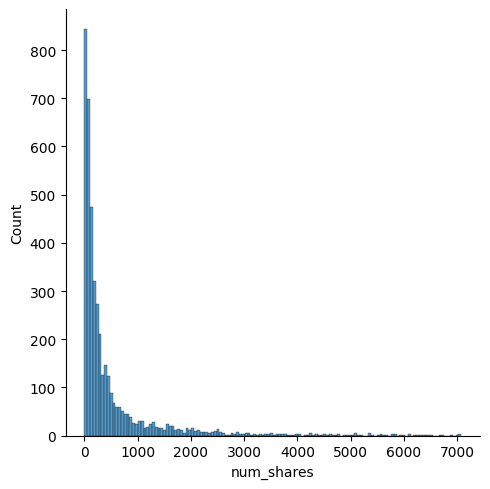

Skew for num_shares: 3.506132100720713


In [ ]:
# remove outliers
pct99 =  df_raw["num_shares"].quantile(.99)
df_plot = df_raw[df_raw['num_shares'] <= pct99].copy()
sns.displot(df_plot['num_shares'])
plt.show()
print(f"Skew for num_shares:", df_plot['num_shares'].skew())

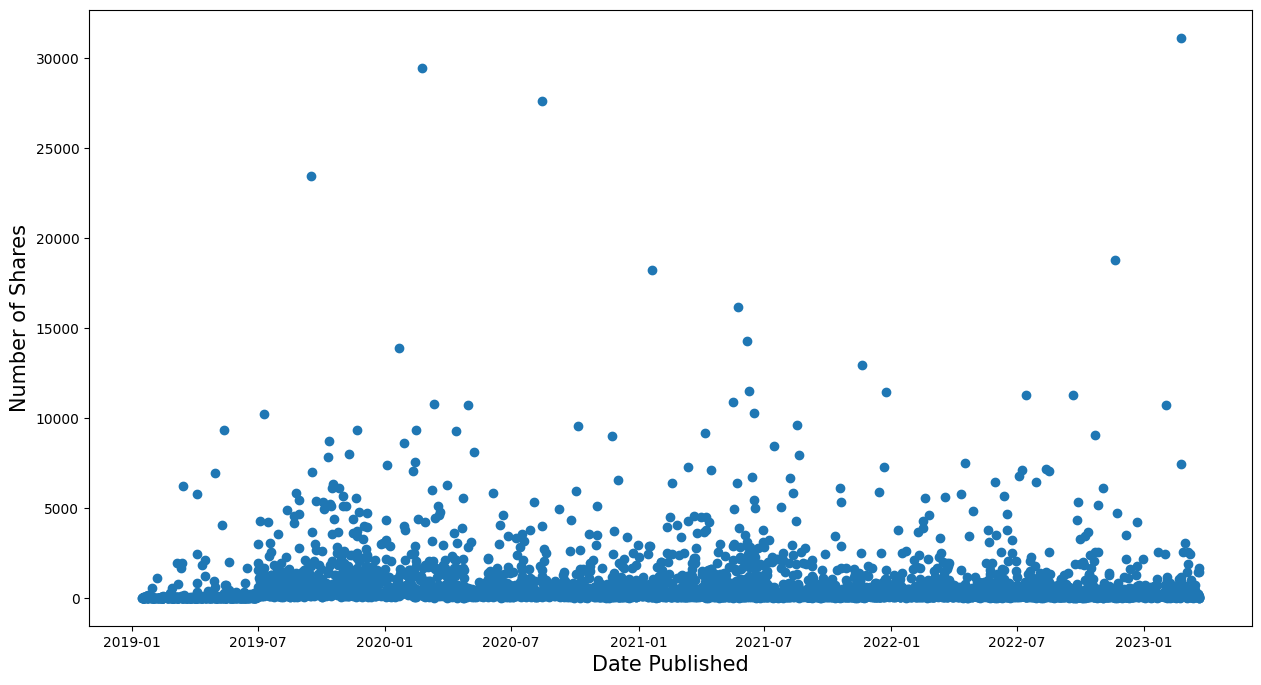

In [ ]:
x_values = df_raw['publish_date']
y_values = df_raw['num_shares']

plt.subplots(figsize=(15,8))
plt.scatter(x_values, y_values)
plt.xlabel('Date Published', fontsize = 15)
plt.ylabel('Number of Shares', fontsize = 15)
plt.show()

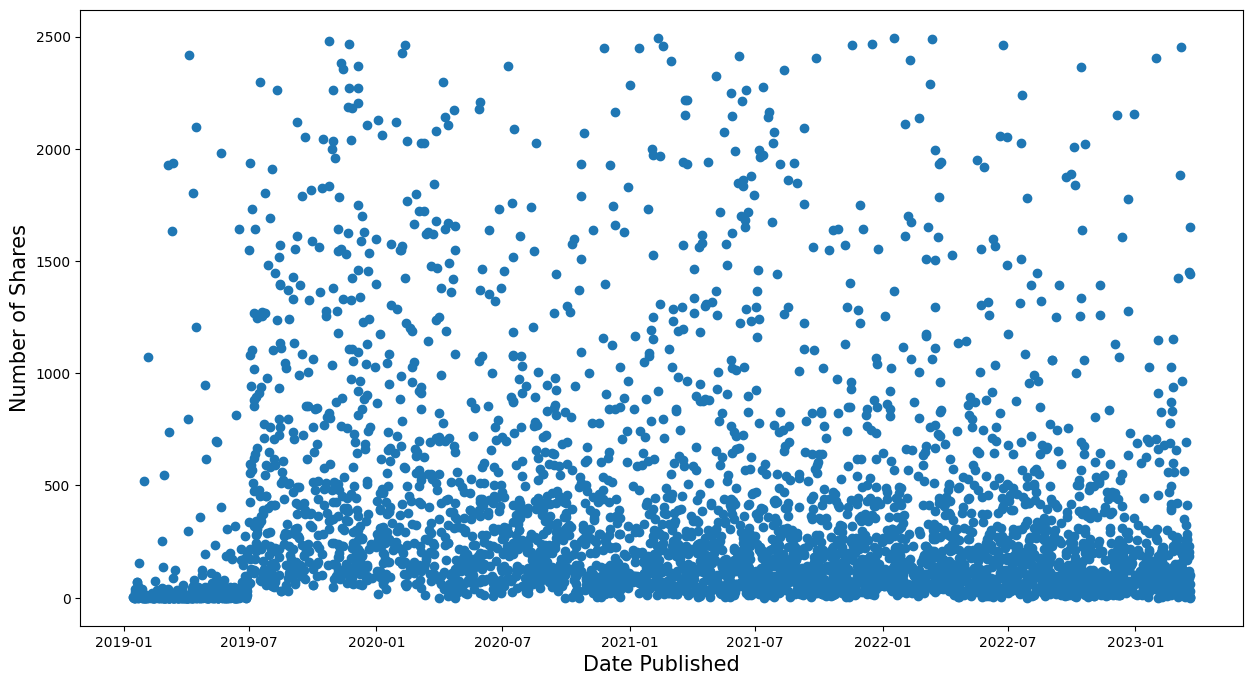

In [ ]:
df_raw_less_1000 = df_raw[df_raw['num_shares'] <= 2500]

x_values = df_raw_less_1000['publish_date']
y_values = df_raw_less_1000['num_shares']

plt.subplots(figsize=(15,8))
plt.scatter(x_values, y_values)
plt.xlabel('Date Published', fontsize = 15)
plt.ylabel('Number of Shares', fontsize = 15)
plt.show()

From the plot above, we can see anomaly in the distribution of number of shares before 2019-07. 

**Therefore we will be ommiting data from before 2019-07**

In [ ]:
df_raw = df_raw[df_raw['publish_date'] >= pd.to_datetime('2019-07-01')]
df_raw.shape

(3991, 12)

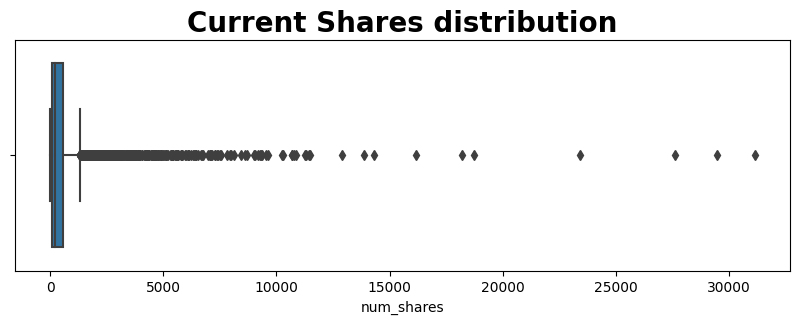

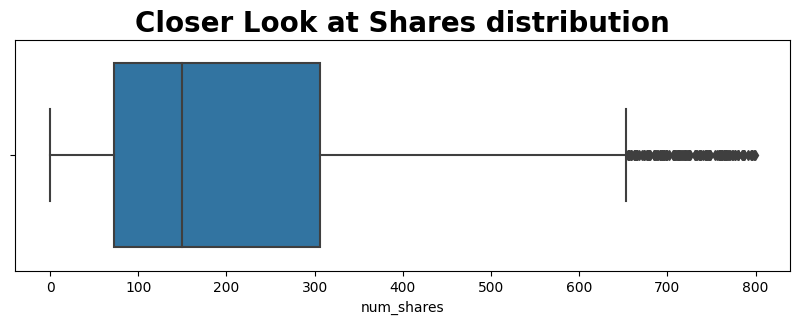

In [ ]:
def plot_boxplot(df, col, title):
    # Plot a boxplot from a dataframe column
    plt.figure(figsize=(10,3))
    plt.title(title, fontsize=20, fontweight='bold')
    sns.boxplot(x=df[col])
    plt.show()

plot_boxplot(df=df_raw,
             col='num_shares',
             title='Current Shares distribution')

# Plot a clearer boxplot of shares distribution with num shares < 800
plot_boxplot(df=df_raw.query("num_shares < 800"),
             col='num_shares',
             title='Closer Look at Shares distribution')

Let's look at the number of shares across different authors.

<Axes: title={'center': 'Top 20 authors with highest average shares per article'}, xlabel='author'>

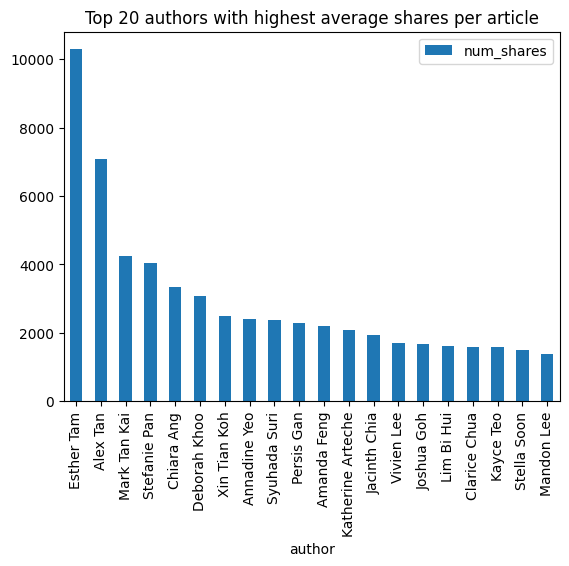

In [ ]:
df_raw[['author','num_shares']].groupby('author').mean().nlargest(20,'num_shares').plot(
    kind='bar',title='Top 20 authors with highest average shares per article')

<Axes: title={'center': 'Top 20 authors with most number of articles published'}>

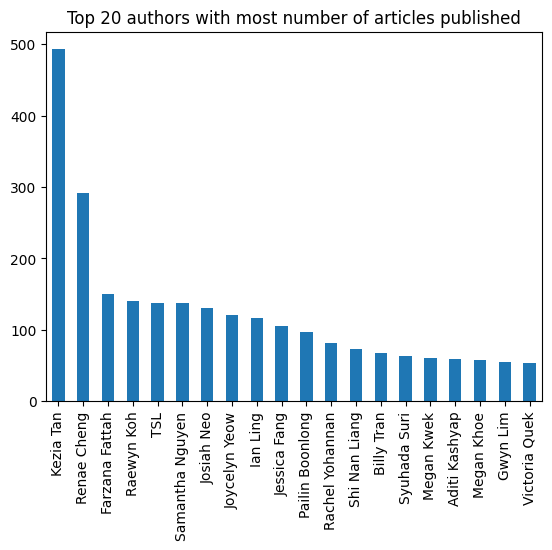

In [ ]:
df_raw['author'].value_counts().nlargest(20).plot(kind='bar',
    title = 'Top 20 authors with most number of articles published')

From the plots above, it seems that writing more articles does not guarantee a higher average number of shares for authors.

# Feature Engineering

### Utility Functions

In [ ]:
def get_non_stop_words_rate(text, stopwords):
    """
    Returns a tuple of proportion of non stopwords in text and
    proportion of unique non stopwords in text.
    """
    tokens = text.split()
    new_text = text
    for sw in stopwords:
        new_text = re.sub(pattern=f'\s*{sw}\s*', repl=' ', string=new_text)
    non_stop_words_tokens = new_text.split()
    
    # Proportion of non stopwords in text
    rate = len(non_stop_words_tokens)/len(tokens)
    
    # Proportion of unique non stopwords in text
    unique_rate = len(set(non_stop_words_tokens))/len(set(tokens))
    
    return rate, unique_rate

def get_sentiment(text):
    """
    Returns a tuple of polarity and sentiment of text, 
    Polarity values are in the range of [-1, 1], 
    -1: negative, 1: positive.
    Sentiment values in the range of [0, 1],
    0: objective, 1: subjective.
    """
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return (sentiment.polarity, sentiment.subjectivity)

def remove_start_end(text):
    text = re.sub('Follow us on Telegram for the latest updates: https://t.me/TSLMedia ', '', text)
    text = re.sub(" Get more stories like this. Drop us your email so you won't miss the latest news. Name Your Name Email Your Email Subscribe", '', text)
    return text

def lemmatize(text: str) -> str:
    """Converts a text into its lemmatized form."""
    wnl = WordNetLemmatizer()
    return ' '.join([wnl.lemmatize(word) for word in text.split()])

def remove_punctuations(text: str) -> str:
    """Removes punctuations and keeps all alphanumerical text."""
    return re.sub(r'[^\w\s]', '', text)

def remove_tags(text):
    # removes social media tags
    return re.sub('@\w+', '', text.lower())

def remove_stopwords(text, stopwords):
    """Removes stopwords from text."""
    for s in stopwords:
        pattern = f' {s} '
        text = re.sub(pattern, ' ', text)
    return text

## Main Categories
There are currently 5 main categories on the website's navigation bar - Travel, Things To Do, Local and Adulting, and Reviews. They will be used to group the subcategories into main categories. As some articles have more than one subcategory, the main category will be based on the first subcategory.

In [ ]:
# Main categories - Can be found on the top navigation bar of website
# Travel category
southeast_asia = ['Thailand', 'Malaysia', 'Philippines', 'Indonesia',
                  'Vietnam']
rest_of_asia = ['China', 'Hong Kong', 'Japan', 'Korea', 'Taiwan', 'Others']
travel = ['Southeast Asia', 'Rest Of Asia', 'Australia', 'New Zealand',
          'Europe', 'Africa & Middle East', 'America', 'Rest of the World',
          'Travel Guides & Tips']
travel_cat = southeast_asia + rest_of_asia + travel + ['Travel']

# Things To Do category
activities = ['Attractions', 'Volunteering']
events = ['Runs']
food = ['Food Reviews', 'Food Guides']
nightlife = ['Bars & Clubs', 'Nightlife Guides']
hotels_and_staycations = ['Hotel Reviews', 'Hotel Guides']
sales_and_promotions = ['Contests', 'Monthly Lobangs']
things_to_do = ['Activities', 'Events', 'Food', 'Nightlife',
                'Hotels & Staycations', 'Family & Kid-friendly', 'Photospots',
                'Sales & Promotions', 'Sports & Fitness', 'Beauty & Wellness',
                'Fashion', 'Gaming']
singapore = ['Things To Do In Singapore', 'Singapore']
things_to_do_cat = (activities + events + food + nightlife
                    + hotels_and_staycations + sales_and_promotions
                    + things_to_do + singapore + ['Things To Do'])

# Local category
local = (['Perspectives', 'Inspiration', 'Culture', 'Students', 'Businesses',
          'Hacks', 'Heritage', 'Supernatural & Mystery', 'Humour', 'Misc'] + 
         ['Local', 'Singapore Perspectives', 'Tutorials & Self-Improvement'])

# Adulting category
parenting = ['Education']
adulting = ['Finances', 'Home', 'Dating & Relationships', 'Wedding', 'Parenting',
            'Career', 'Self Improvement', 'Pets', 'Tech', 'Products']
adulting_cat = parenting + adulting + ['Adulting', 'Cryptocurrency']

# Reviews
reviews = ['Reviews']

# Create dictionary of subcategory to one of the 5 main categories
subcat_to_travel = {subcat:'Travel' for subcat in travel_cat} 
subcat_to_things_to_do = {subcat:'Things To Do' for subcat in things_to_do_cat}
subcat_to_local = {subcat:'Local' for subcat in local}
subcat_to_adulting = {subcat:'Adulting' for subcat in adulting_cat}
subcat_to_reviews = {subcat:'Reviews' for subcat in reviews}

# Combine all dictionaries into one
subcat_to_main_cat = {**subcat_to_travel, **subcat_to_things_to_do,
                      **subcat_to_local, **subcat_to_adulting,
                      **subcat_to_reviews}

In [ ]:
# Split subcategory column into 3 columns as there are articles with
# >1 subcategory
categories = df_raw.subcategory.str.split(pat=',', n=2, expand=True)

categories.columns = ['subcategory1', 'subcategory2', 'subcategory3']

# Get main category from the overall dictionary
categories.insert(loc=0,
                  column='category',
                  value=categories.subcategory1.apply(lambda x:
                                                      subcat_to_main_cat[x]))

# Drop original subcategory column and add the main and sub categories
# into the dataframe
df_fe = pd.concat(objs=[df_raw.loc[:, :'title'],categories,
                        df_raw.loc[:, 'preview':]],axis=1)

## Time Delta
Number of days between the article's publish date and the date of web scraping (21 March 2023)

In [ ]:
# Convert publish date column to datetime format
df_fe.publish_date = pd.to_datetime(arg=df_fe.publish_date,
                                         format='%Y-%m-%d')

timedelta = (datetime.date(2023, 3, 21) -
             df_fe.publish_date.dt.date).dt.days

# Insert timedelta after url column
insertion_index = df_fe.columns.get_loc('url') + 1

df_fe.insert(loc=insertion_index, column='timedelta', value=timedelta)

## Day of the Week, Month, Year
Extracted from publication date

In [ ]:
# Get days of the week from publish date. 0: Monday 6: Sunday
days_of_week = df_fe.publish_date.apply(lambda x: x.weekday())

month = df_fe.publish_date.dt.month
year = df_fe.publish_date.dt.year

# Insert day_of_week after publish_date column
insertion_index = df_fe.columns.get_loc('publish_date') + 1
df_fe.insert(loc=insertion_index,
                  column='day_of_week',
                  value=days_of_week)

# Insert day_of_week after day_of_week column
insertion_index = df_fe.columns.get_loc('day_of_week') + 1
df_fe.insert(loc=insertion_index, column='month', value=month)

# Insert day_of_week after month column
insertion_index = df_fe.columns.get_loc('month') + 1
df_fe.insert(loc=insertion_index, column='year', value=year)

# Convert publication date to date format for exporting purposes
df_fe.publish_date = df_fe.publish_date.dt.date

## Author

In [ ]:
# Top 20 authors based on number of blogpost
authors = df_fe.author.value_counts().to_frame()
authors.head()

author
Kezia Tan          493
Renae Cheng        292
Farzana Fattah     150
Raewyn Koh         140
TSL                138

<Axes: ylabel='Count'>

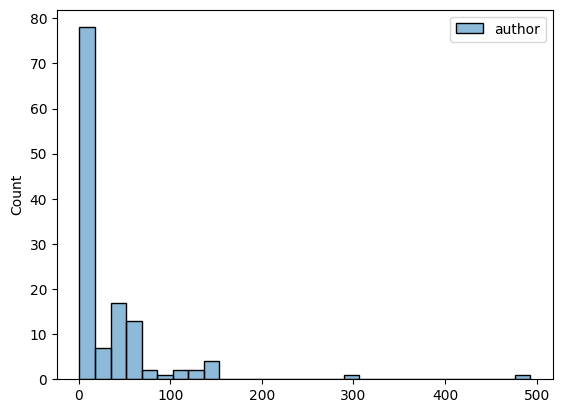

In [ ]:
sns.histplot(authors)

In [ ]:

def categorise_authors(x):
    if x > 200:
        return "More than 200 posts"
    elif x > 100:
        return "100 to 200 posts"
    elif x > 50:
        return "50 to 100 posts"
    else:
        return "Less than 50 posts"

In [ ]:
authors["category"] = authors.author.apply(lambda x: categorise_authors(x))
df_fe["author_category"] = df_fe.author.apply(lambda x: authors._get_value(x, "category"))

## Text Features

### Tokenization
n_tokens: Count of text in title and content

In [ ]:
# Word count of preview - numbers and punctuations are still kept
n_tokens_preview = df_fe.preview.apply(lambda x: len(x.split()))

# Word count of title - numbers and punctuations are still kept
n_tokens_title = df_fe.title.apply(lambda x: len(x.split()))

# Word count of article content - punctuations are removed but numbers
# are kept
n_tokens_content = df_fe.content.apply(lambda x: len(remove_punctuations(x).split()))

# Insert n_tokens_title after content column
insertion_index = df_fe.columns.get_loc('content') + 1
df_fe.insert(loc=insertion_index,
              column='n_tokens_title',
              value=n_tokens_title)

# Insert n_tokens_preview after n_tokens_title column
insertion_index = df_fe.columns.get_loc('n_tokens_title') + 1
df_fe.insert(loc=insertion_index,
              column='n_tokens_preview',
              value=n_tokens_preview)

# Insert n_tokens_content after n_tokens_title column
insertion_index = df_fe.columns.get_loc('n_tokens_preview') + 1
df_fe.insert(loc=insertion_index,
              column='n_tokens_content',
              value=n_tokens_content)

### Stop word removal

Before finding the proportion of non stop words in each article, it is important to find other potential stop words to extend the list.

In [ ]:
# Combine all article content into a single string
total_content = ' '.join(df_fe['content'])
total_content_lemma = lemmatize(remove_punctuations(total_content.lower()))

# Word frequency dictionary
word_to_frequency = FreqDist()

for sentence in nltk.tokenize.sent_tokenize(total_content_lemma):
    for word in nltk.tokenize.word_tokenize(sentence):
        if word not in string.punctuation:
            word_to_frequency[word] += 1

freq_df = pd.DataFrame.from_dict(word_to_frequency.items())
freq_df.columns = ['word', 'frequency']
freq_df.sort_values(by='frequency', ascending=False, inplace=True)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

word  frequency
0  the     204767
1    a     153288
2   to     151681
3  and     125469
4   of      99079

In [ ]:
k, v = zip(*word_to_frequency.most_common())

# Default stop words
stop_words = stopwords.words('english')

# Get non stop words with highest frequency across all articles
non_stop_words = [x for x in k if x not in stop_words]

# Top 20 non stop words
non_stop_words[:20]

['image',
 'credit',
 'singapore',
 'like',
 'get',
 'also',
 'one',
 'u',
 'youre',
 'email',
 'time',
 'youll',
 'wa',
 'hour',
 'even',
 'ha',
 'name',
 'day',
 'latest',
 'new']

It can be seen that "image" and "credit" are the most frequent words as the articles often include image credits. Hence, the bigram "image credit" can be added into the stop words corpus, along with different variations of it. In addition, "wa" and "ha" will be included in the corpus.

In [ ]:
print(df_fe['content'].str.contains(
    'Follow us on Telegram for the latest updates: https://t.me/TSLMedia',
    na=False).sum())
print(df_fe['content'].str.contains(
    "Get more stories like this. Drop us your email so you won't miss the latest news. " + \
    "Name Your Name Email Your Email Subscribe"
    ,na=False).sum())

3991
3991


From our observations, we also notice majority of the content start with "Follow us on Telegram for the latest updates: https://t.me/TSLMedia" and end with "Get more stories like this. Drop us your email so you won't miss the latest news. Name Your Name Email Your Email Subscribe", hence we will be removing those too under the function remove_start_end.

In [ ]:
# Extend stop words
stop_words = ['cover image adapted from', 'cover image credits',
              'cover image credit', 'image credits', 'image credit',
              'image adapted from', 'photography by', 'ha', 'wa'] + stop_words

# Functions to apply
functions = [remove_start_end, remove_tags, contractions.fix, remove_punctuations, lemmatize, 
             lambda x: get_non_stop_words_rate(text=x, stopwords=stop_words)]
mass_apply = lambda x: reduce(lambda y, f: f(y), functions, x)

rates = df_fe['content'].apply(mass_apply)
prop_non_stop = rates.str[0]
prop_unique_non_stop = rates.str[1]

# Insert n_tokens_title after n_tokens_content column
insertion_index = df_fe.columns.get_loc('n_tokens_content') + 1
df_fe.insert(loc=insertion_index,
              column='prop_non_stop',
              value=prop_non_stop)

# Insert n_tokens_title after prop_non_stop column
insertion_index = df_fe.columns.get_loc('prop_non_stop') + 1
df_fe.insert(loc=insertion_index,
              column='prop_unique_non_stop',
              value=prop_unique_non_stop)

### Polarity and Subjectivity
Before getting the polarity and subjectivity of the titles and content through the textblob library, preprocessing of text is performed:
- removal of social media tags (e.g. @instagram)
- uncontracting words (you've to you have); limitation: I'd will be uncontracted to I would by default, instead of I had
- removal of punctuations
- removal of stop words
- lemmatization

In [ ]:
# Functions to process text by removing social media tags, uncontracting
# words, removing punctuations and stop words

functions = [remove_start_end, remove_tags, contractions.fix, remove_punctuations,
             lambda x: remove_stopwords(text=x, stopwords=stop_words), lemmatize]

mass_apply = lambda x: reduce(lambda y, f: f(y), functions, x)

# Process title and content
title_processed = df_fe['title'].apply(mass_apply)
preview_processed = df_fe['preview'].apply(mass_apply)
content_processed = df_fe['content'].apply(mass_apply)

title_processed_sentiment = title_processed.apply(get_sentiment)
preview_processed_sentiment = preview_processed.apply(get_sentiment)
content_processed_sentiment = content_processed.apply(get_sentiment)

title_df = pd.DataFrame(data=title_processed_sentiment.tolist(),
                          columns=['title_polarity', 'title_subjectivity'])
preview_df = pd.DataFrame(data=preview_processed_sentiment.tolist(),
                          columns=['preview_polarity', 'preview_subjectivity'])
content_df = pd.DataFrame(data=content_processed_sentiment.tolist(),
                          columns=['content_polarity', 'content_subjectivity'])

df_fe = pd.concat(objs=[df_fe.loc[:,:'n_tokens_title'], title_df.set_index(df_fe.index),
                        df_fe.loc[:,'n_tokens_preview'], preview_df.set_index(df_fe.index),
                        df_fe.loc[:,'n_tokens_content'], content_df.set_index(df_fe.index),
                        df_fe.loc[:,'prop_non_stop':]], axis=1)

In [ ]:
preview_processed

0       there elevated mezzanine seating area fairy li...
1       the hyperrealistic virtual skyscraper game sen...
2       thankfully great game require portion paycheck...
3       if looking outdoor adventure beyond location l...
4                    fan tayo little bus right way please
                              ...                        
3987    enjoy july 2019 handful lobangs stretch dollar...
3988    how make bathroom luxe would taking extralong ...
3989    the new capri fraser china square staycays res...
3990    thing july 2019 like half year gone smack midd...
3991    skillsfuture course singapore know officially ...
Name: preview, Length: 3991, dtype: object

In [ ]:
title_processed

0       kampong gelam bazaar 2023 light projection sul...
1       headrock vr virtual reality theme park sentosa...
2       30 free steam game add library coop shooter ho...
3       marina south pier ferry ride southern island r...
4       tayo station massive indoor playground multi z...
                              ...                        
3987    12 best lobangs july 2019 1for1 mookata buffet...
3988    5 bathroom fitting hdb singapore give 5star sh...
3989    capri fraser new igfriendly hotel cbd gym pool...
3990    20 thing july 2019 50cents fest street fighter...
3991    6 useful skillsfuture course singaporean learn...
Name: title, Length: 3991, dtype: object

In [ ]:
content_processed

0       kampong gelam bazaar 2023 every ramadan muslim...
1       headrock vr singapore looking fun activity ide...
2       free steam game play home gamers singapore agr...
3       marina south pier guide looking outdoor advent...
4       tayo station downtown east kid want play care ...
                              ...                        
3987    best deal singapore july 2019 karaoke manekine...
3988    bathroom fitting hbd singapore hansgrohe long ...
3989    the new capri fraser china square staycays res...
3990    thing july 2019 like half year gone smack midd...
3991    skillsfuture course singapore know officially ...
Name: content, Length: 3991, dtype: object

## Feature Crossing

We will also add new columns via feature crossing.

In [ ]:
# cross by metric
df_fe['n_tokens_cross'] = df_fe['n_tokens_title'] * \
                          df_fe['n_tokens_preview'] * \
                          df_fe['n_tokens_content']

df_fe['polarity_cross'] = df_fe['title_polarity'] * \
                          df_fe['preview_polarity'] * \
                          df_fe['content_polarity']

df_fe['subjectivity_cross'] = df_fe['title_subjectivity'] * \
                              df_fe['preview_subjectivity'] * \
                              df_fe['content_subjectivity']

In [ ]:
# cross by section
df_fe['title_cross'] = df_fe['n_tokens_title'] * \
                        df_fe['title_polarity'] * \
                        df_fe['title_subjectivity']
                                
df_fe['preview_cross'] = df_fe['n_tokens_preview'] * \
                          df_fe['preview_polarity'] * \
                          df_fe['preview_subjectivity']

df_fe['content_cross'] = df_fe['n_tokens_content'] * \
                          df_fe['content_polarity'] * \
                          df_fe['content_subjectivity'] 

In [ ]:
# cross prop
df_fe['prop_cross'] = df_fe['prop_non_stop'] * df_fe['prop_unique_non_stop']

# EDA on updated dataset

With the addition of feature engineered columns, we will conduct another round of EDA.

In [ ]:
len(df_fe.columns)

38

In [ ]:
df_fe.head()

url  timedelta  \
0  https://thesmartlocal.com/read/kampong-gelam-b...          0   
1        https://thesmartlocal.com/read/headrock-vr/          0   
2   https://thesmartlocal.com/read/free-steam-games/          0   
3  https://thesmartlocal.com/read/marina-south-pier/          0   
4  https://thesmartlocal.com/read/tayo-station-si...          0   

                                               title      category  \
0  Kampong Gelam Bazaar 2023 Has Light Projection...  Things To Do   
1  HeadRock VR: Virtual Reality Theme Park At Sen...  Things To Do   
2  30 Free Steam Games To Add To Your Library Fro...  Things To Do   
3  Marina South Pier: Ferry Rides To The Southern...  Things To Do   
4  Tayo Station Is A Massive Indoor Playground Wi...  Things To Do   

            subcategory1 subcategory2 subcategory3  \
0             Activities         None         None   
1            Attractions         None         None   
2                 Gaming         None         None   
3             Activities         None         None   
4  Family & Kid-friendly         None         None   

                                             preview  \
0  There’s an elevated mezzanine seating area wit...   
1  The hyper-realistic virtual skyscraper game se...   
2  Thankfully, not all great games require a port...   
3  If you’re looking for an outdoor adventure bey...   
4  Fans of Tayo The Little Bus, right this way pl...   

                                             content  n_tokens_title  ...  \
0  Follow us on Telegram for the latest updates: ...              17  ...   
1  Follow us on Telegram for the latest updates: ...              14  ...   
2  Follow us on Telegram for the latest updates: ...              15  ...   
3  Follow us on Telegram for the latest updates: ...              14  ...   
4  Follow us on Telegram for the latest updates: ...              16  ...   

   num_tags  num_shares      author_category  n_tokens_cross  polarity_cross  \
0         1           1   Less than 50 posts          234957        0.032119   
1         2           1  More than 200 posts          222264        0.000556   
2         2        1650      50 to 100 posts         1162800        0.000000   
3         6        1441      50 to 100 posts          289912        0.000000   
4         4          63     100 to 200 posts          108000        0.002280   

   subjectivity_cross  title_cross  preview_cross  content_cross  prop_cross  
0            0.189258        4.760       2.805000     106.970288    0.351511  
1            0.193125       -0.735      -2.245775      14.457958    0.424494  
2            0.188552        0.000       1.593056     143.063801    0.283420  
3            0.000000        0.000       0.000000      27.019015    0.482113  
4            0.220603        4.560       0.254305      46.852851    0.454961  

[5 rows x 38 columns]

In [ ]:
df_fe.isnull().sum()

url                        0
timedelta                  0
title                      0
category                   0
subcategory1               0
subcategory2            3893
subcategory3            3990
preview                    0
content                    0
n_tokens_title             0
title_polarity             0
title_subjectivity         0
n_tokens_preview           0
preview_polarity           0
preview_subjectivity       0
n_tokens_content           0
content_polarity           0
content_subjectivity       0
prop_non_stop              0
prop_unique_non_stop       0
reading_duration           0
author                     0
publish_date               0
day_of_week                0
month                      0
year                       0
num_imgs                   0
num_hrefs                  0
num_tags                   0
num_shares                 0
author_category            0
n_tokens_cross             0
polarity_cross             0
subjectivity_cross         0
title_cross   

Since subcategory2 and subcategory3 has a lot of missing values and it is likely that they are not as relevant as the first subcategory, **we will be dropping those 2 columns**.


In [ ]:
df_fe.drop(['subcategory2', 'subcategory3'], axis=1, inplace = True)

In [ ]:
categorical_cols = ['category', 'subcategory1', 'author', 'day_of_week', 'month']
continuous_cols = ['n_tokens_title','title_polarity','title_subjectivity','n_tokens_preview', 
                   'preview_polarity', 'preview_subjectivity', 'n_tokens_content', 'content_polarity', 
                   'content_subjectivity', 'prop_non_stop', 'prop_unique_non_stop', 'reading_duration',
                   'num_imgs','num_hrefs', 'num_tags']
time_cols = ['publish_date', 'year', 'timedelta']
target_var = ['num_shares']
other_cols = ['url', 'title', 'preview', 'content']

## Continuous variables

In [ ]:
# conduct corr test on continuous variables and target variables
df_fe.describe()

timedelta  n_tokens_title  title_polarity  title_subjectivity  \
count  3991.000000     3991.000000     3991.000000         3991.000000   
mean    635.645953       16.006515        0.147469            0.362628   
std     388.503419        2.325183        0.297036            0.306080   
min       0.000000        7.000000       -1.000000            0.000000   
25%     297.000000       15.000000        0.000000            0.000000   
50%     608.000000       16.000000        0.025000            0.383333   
75%     956.500000       18.000000        0.300000            0.577273   
max    1359.000000       24.000000        1.000000            1.000000   

       n_tokens_preview  preview_polarity  preview_subjectivity  \
count        3991.00000       3991.000000           3991.000000   
mean           21.19544          0.148034              0.392434   
std             6.69271          0.267442              0.296410   
min             2.00000         -1.000000              0.000000   
25%            17.00000          0.000000              0.075962   
50%            22.00000          0.083333              0.408333   
75%            26.00000          0.300000              0.600000   
max            35.00000          1.000000              1.000000   

       n_tokens_content  content_polarity  content_subjectivity  ...  \
count       3991.000000       3991.000000           3991.000000  ...   
mean        1348.641944          0.153976              0.466569  ...   
std          730.748497          0.066605              0.056814  ...   
min          204.000000         -0.125521              0.205215  ...   
25%          853.500000          0.113334              0.429733  ...   
50%         1257.000000          0.154586              0.468085  ...   
75%         1687.000000          0.196545              0.503677  ...   
max        14637.000000          0.410256              0.693954  ...   

         num_hrefs     num_tags    num_shares  n_tokens_cross  polarity_cross  \
count  3991.000000  3991.000000   3991.000000    3.991000e+03     3991.000000   
mean     19.480080     3.111000    690.327487    4.632645e+05        0.007395   
std      19.430824     1.927367   1622.305068    3.238173e+05        0.024275   
min       0.000000     0.000000      0.000000    1.741500e+04       -0.120163   
25%       7.000000     2.000000     89.000000    2.444840e+05        0.000000   
50%      14.000000     3.000000    214.000000    4.074220e+05        0.000000   
75%      27.000000     4.000000    576.500000    6.051600e+05        0.004386   
max     380.000000    17.000000  31131.000000    6.367095e+06        0.315051   

       subjectivity_cross  title_cross  preview_cross  content_cross  \
count         3991.000000  3991.000000    3991.000000    3991.000000   
mean             0.073886     1.229436       1.855549      95.499655   
std              0.098712     2.739016       4.047527      64.820653   
min              0.000000   -17.000000     -27.000000     -93.399150   
25%              0.000000     0.000000       0.000000      51.092392   
50%              0.029087     0.091667       0.600000      83.921546   
75%              0.119350     2.526887       3.360000     127.946115   
max              0.603056    19.000000      30.000000     788.675392   

        prop_cross  
count  3991.000000  
mean      0.383176  
std       0.058734  
min       0.206673  
25%       0.342558  
50%       0.384093  
75%       0.422232  
max       0.698288  

[8 rows x 27 columns]

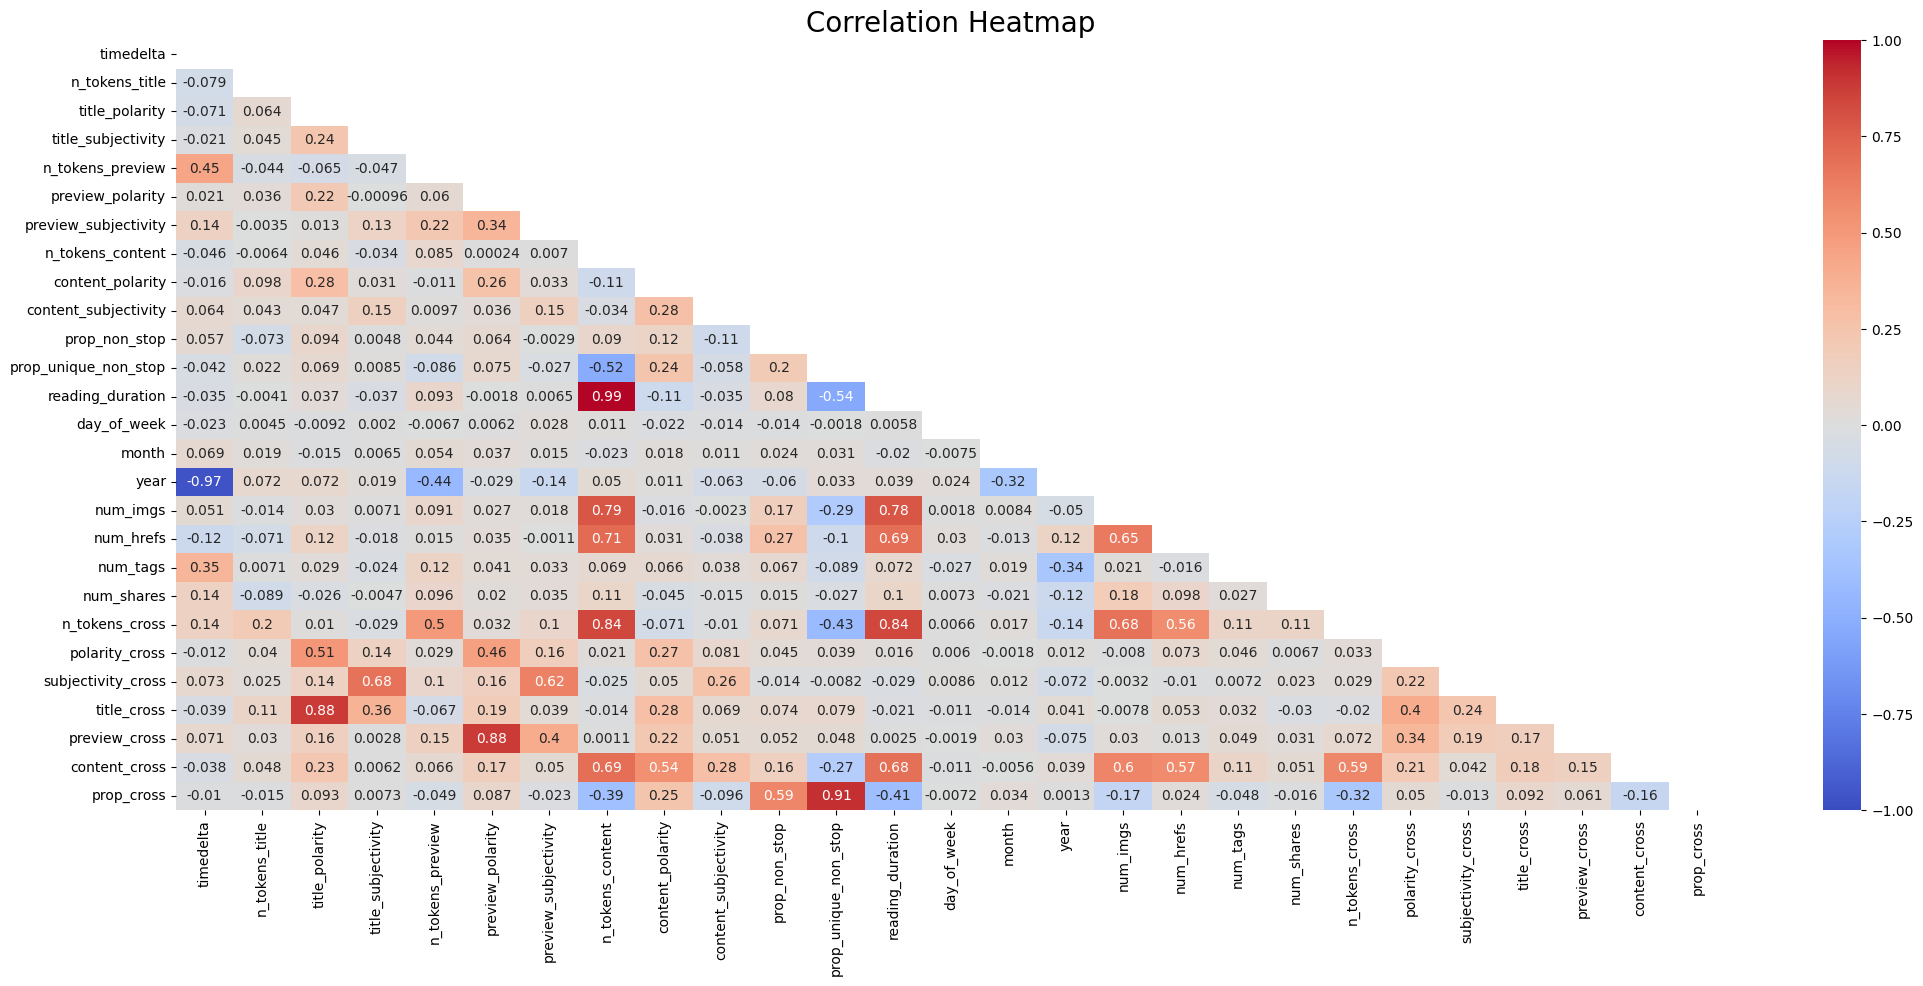

In [ ]:
corr_mat = df_fe.corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25,10))
sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm', mask = mask, vmin=-1, vmax=1, )
plt.title('Correlation Heatmap', fontsize = 20)
plt.show()

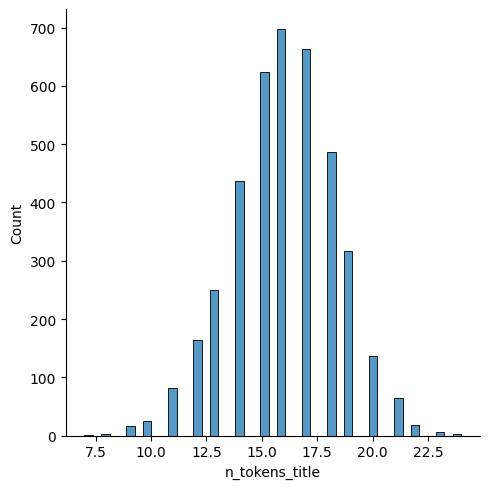

Skew for n_tokens_title: -0.15940700305210898


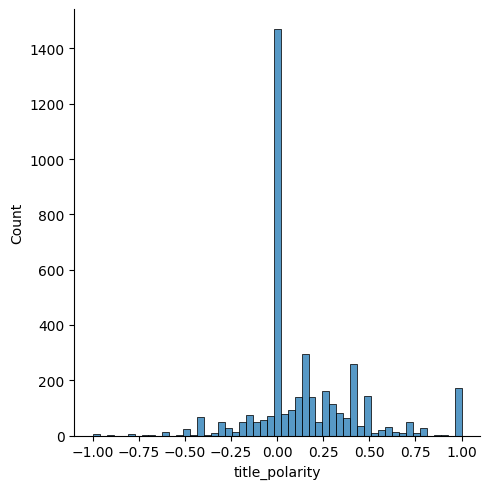

Skew for title_polarity: 0.8465028285095952


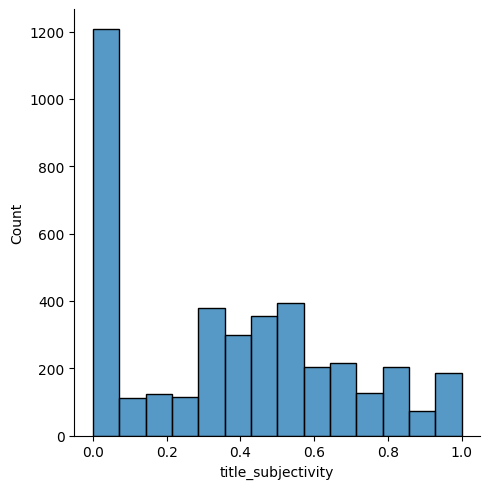

Skew for title_subjectivity: 0.3146808022300395


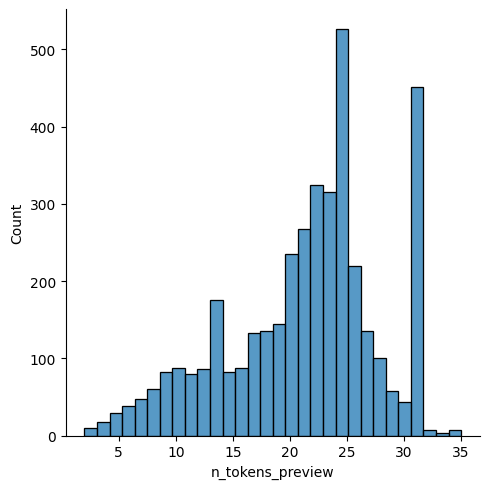

Skew for n_tokens_preview: -0.5187444458059673


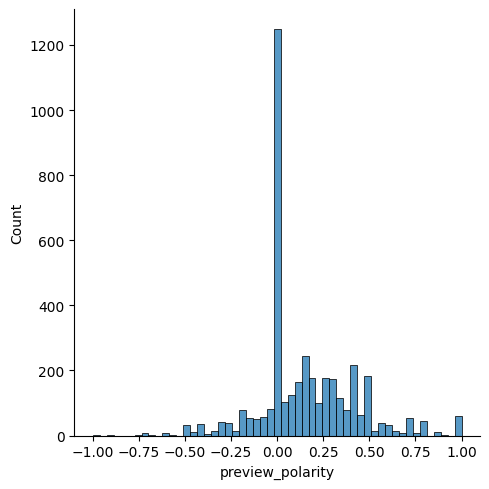

Skew for preview_polarity: 0.5053570937896874


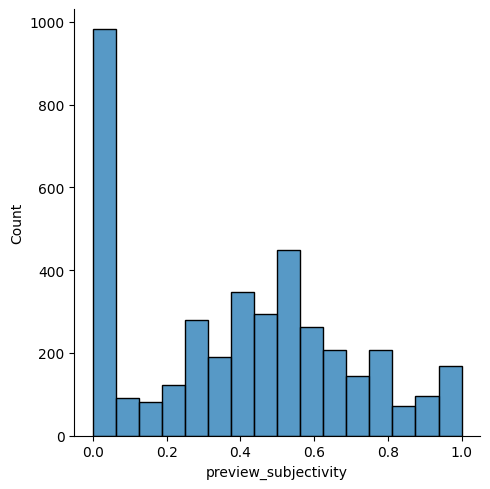

Skew for preview_subjectivity: 0.15105318025277018


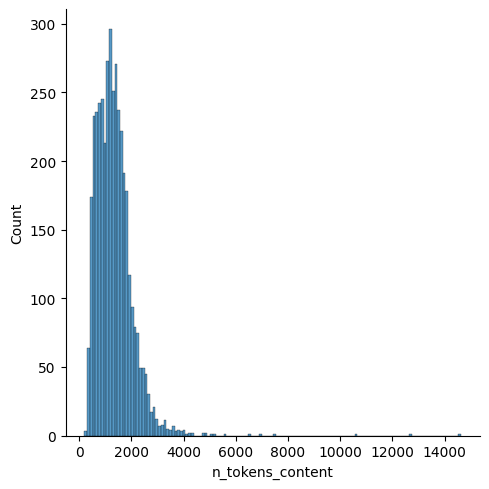

Skew for n_tokens_content: 4.073644083881442


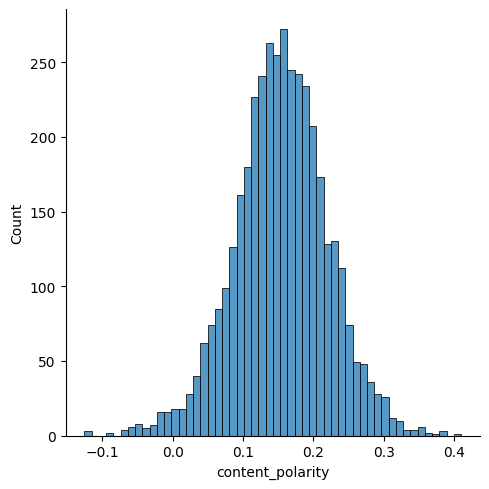

Skew for content_polarity: -0.13795942839692216


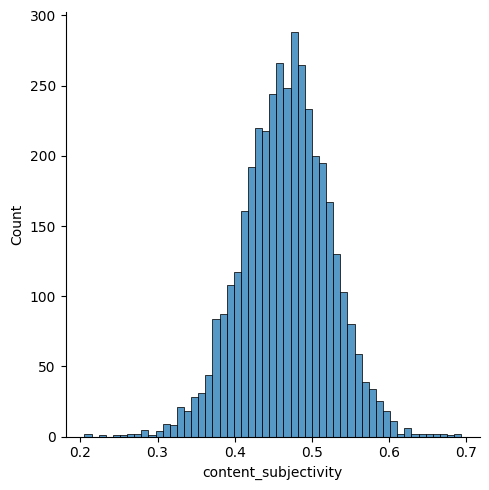

Skew for content_subjectivity: -0.11758760145746895


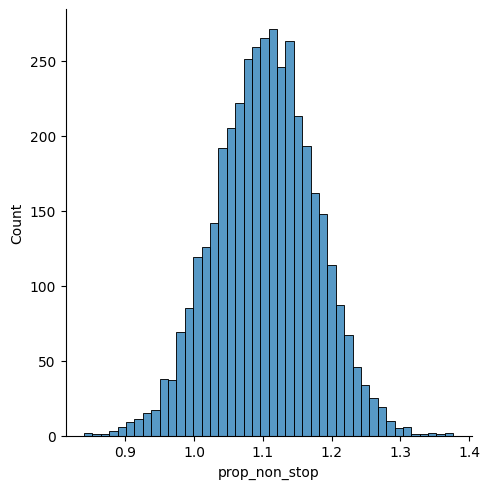

Skew for prop_non_stop: -0.029843252665908503


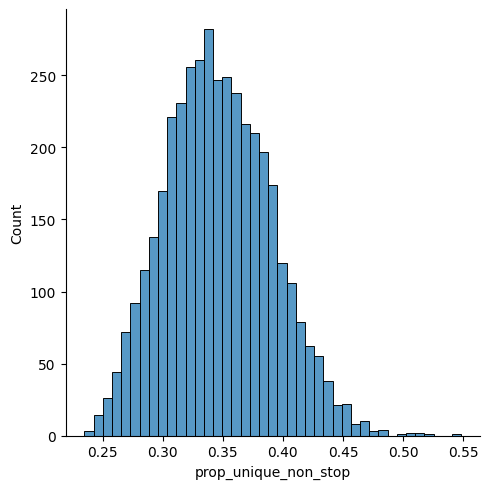

Skew for prop_unique_non_stop: 0.27545057020254915


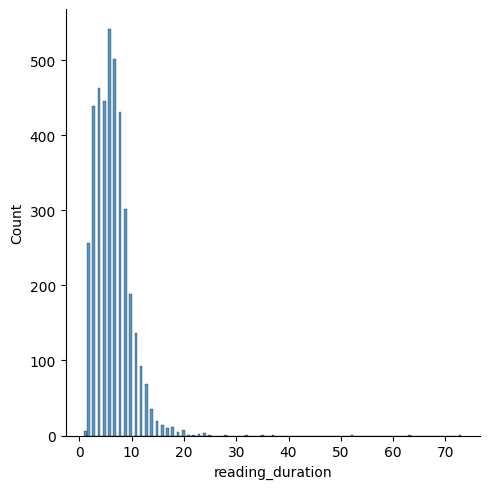

Skew for reading_duration: 4.026069132523188


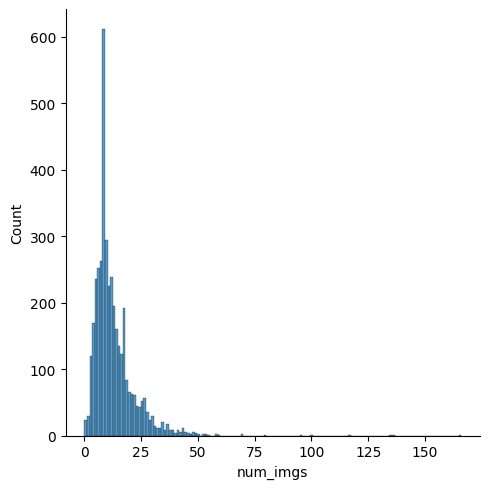

Skew for num_imgs: 4.06157246180137


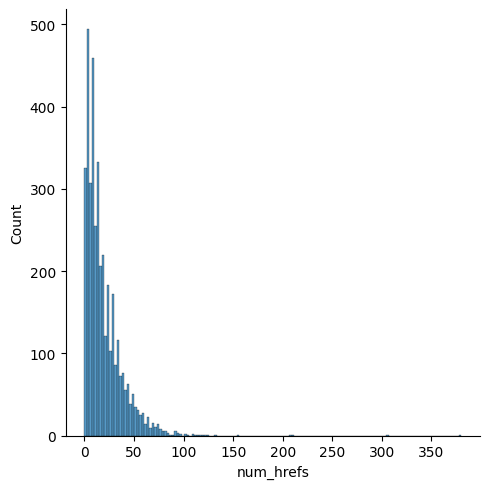

Skew for num_hrefs: 4.1558299256316715


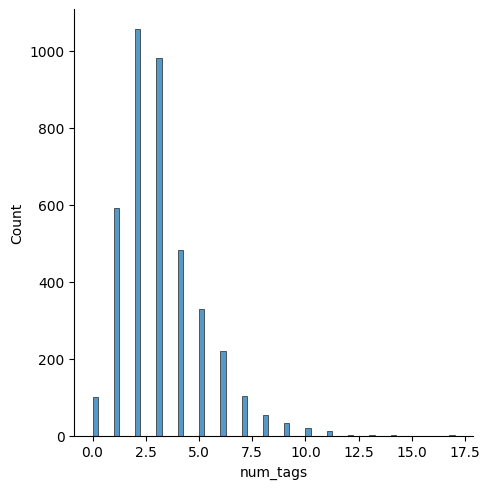

Skew for num_tags: 1.3424219218338


In [ ]:
for col in continuous_cols:
    sns.displot(data=df_fe[continuous_cols], x=col)
    plt.show()
    print(f"Skew for {col}:", df_fe[col].skew())

We remove the top and bottom 5 percentile of the number of shares and plot a scattor plot for all the continuous variables against our target variable (number of shares) to find any correlation.

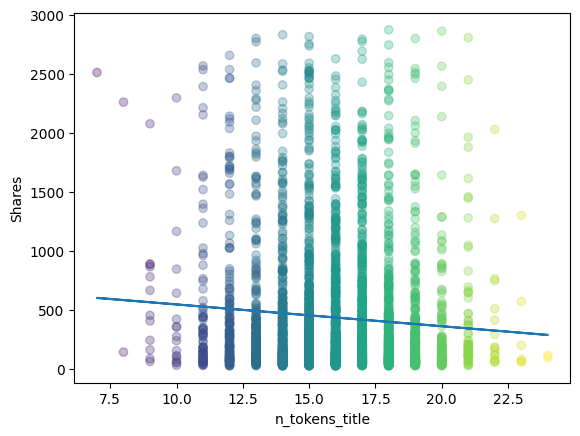

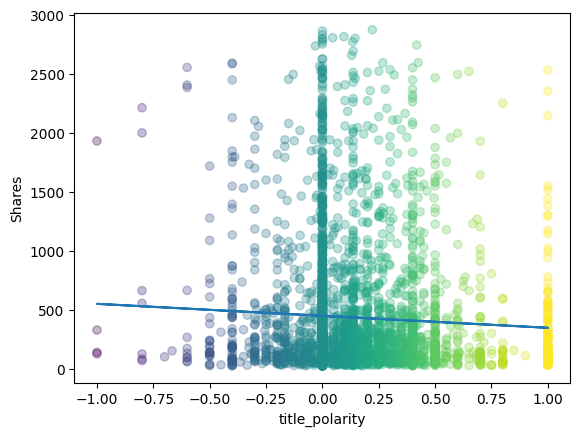

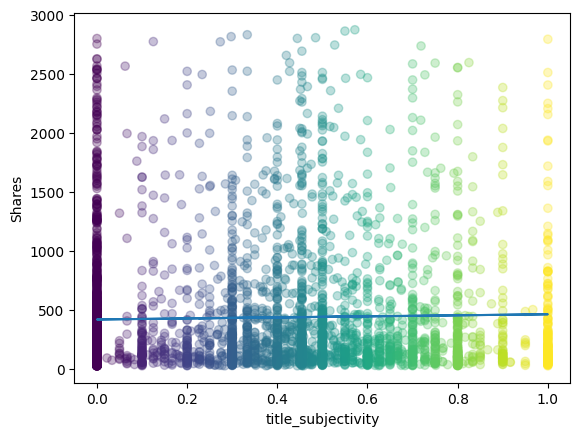

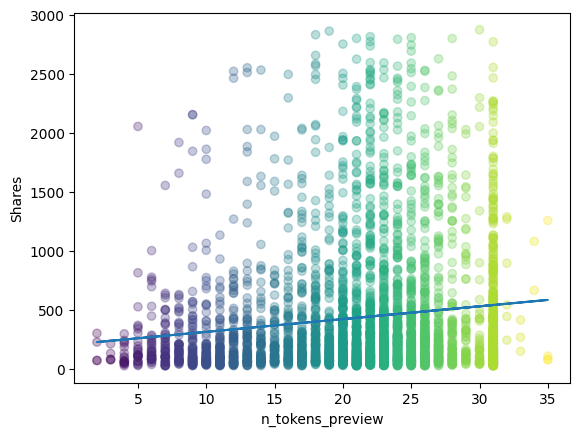

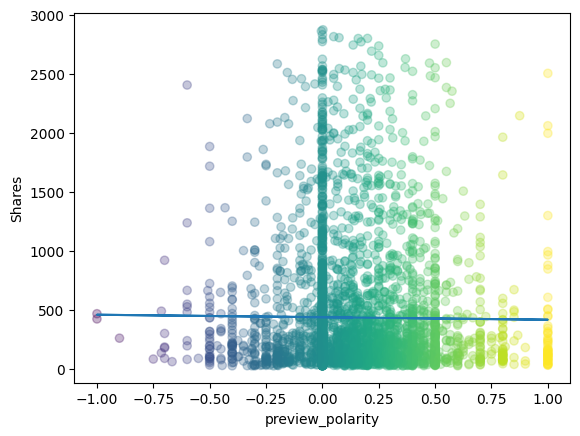

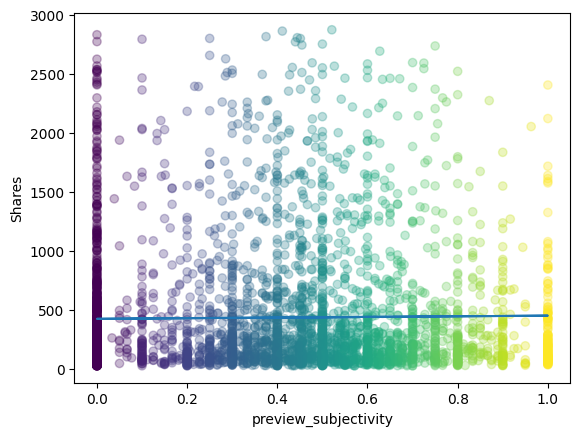

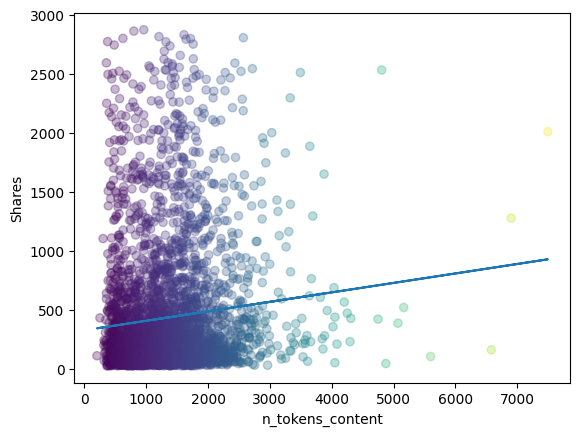

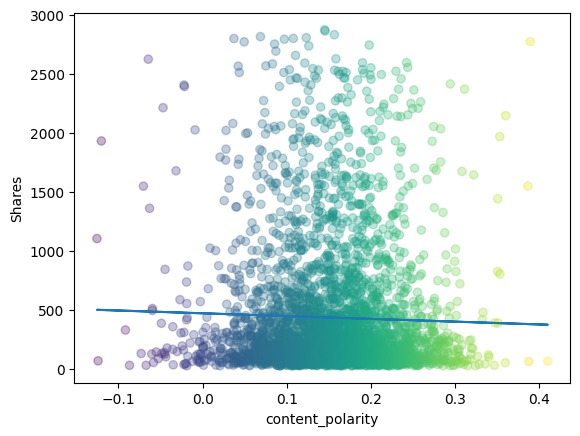

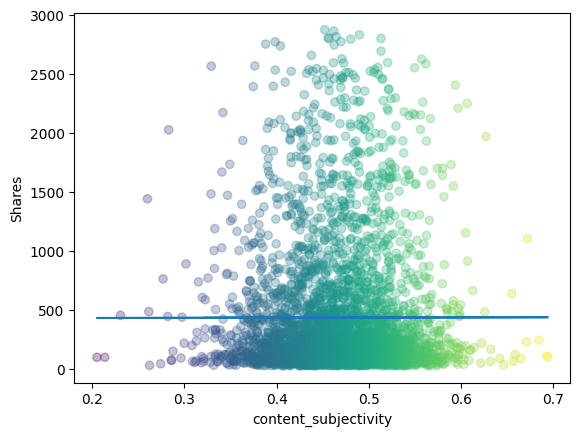

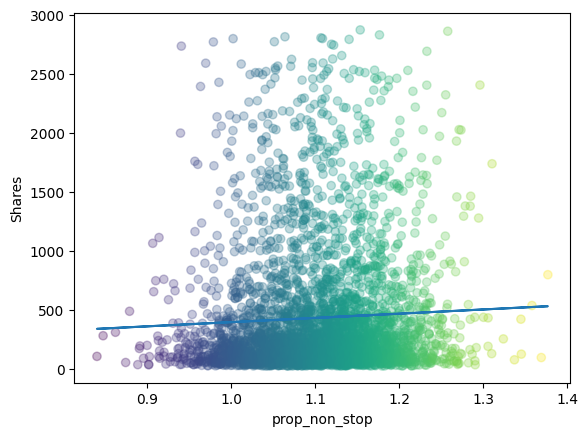

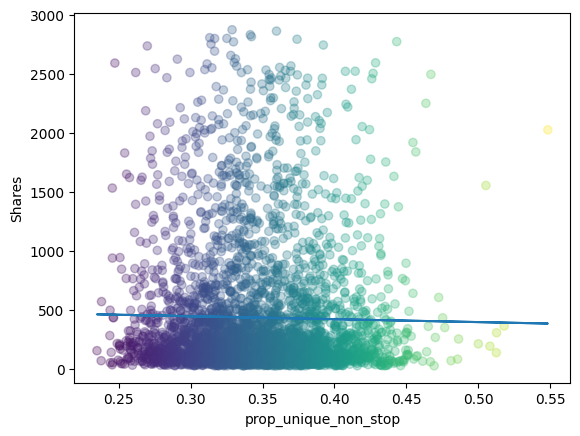

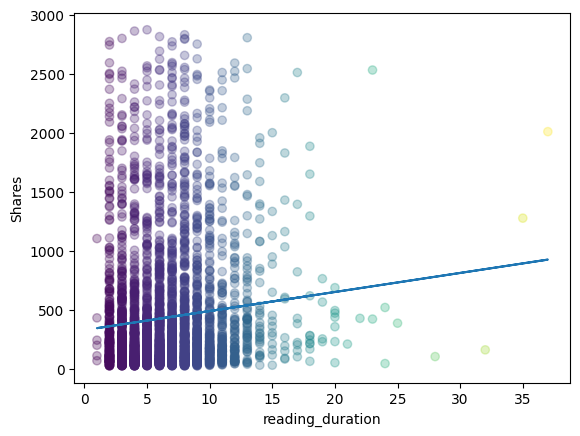

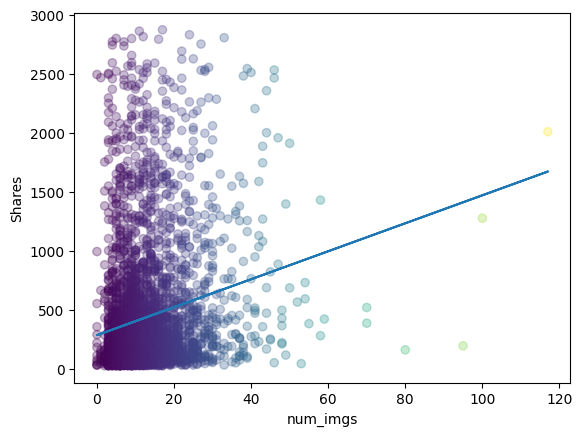

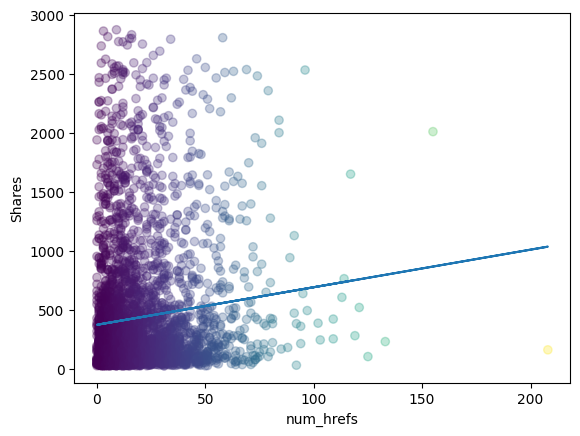

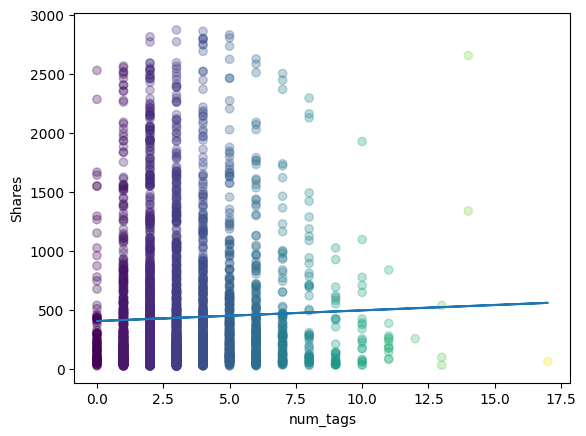

In [ ]:
pct95 =  df_fe["num_shares"].quantile(.95)
pct5 =  df_fe["num_shares"].quantile(.05)
df_95 = df_fe.loc[(df_fe['num_shares'] > pct5) & (df_fe['num_shares'] < pct95)]
for v in continuous_cols:
    x = df_95[v]
    y = df_95['num_shares']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x))
    plt.scatter(x,y, c=x, alpha=0.3, cmap='viridis')
    plt.xlabel(v)
    plt.ylabel("Shares")
    plt.show()

### Bin target variable
and plot against continuous variables.

In [ ]:
quantile_33 = df_fe['num_shares'].quantile(.33)
quantile_67 = df_fe['num_shares'].quantile(.67)

df_fe['num_shares_bin'] = df_fe['num_shares'].apply(lambda x: 'Low Shares' if x <= quantile_33 else 'Average Shares' if x <= quantile_67 else 'High Shares')

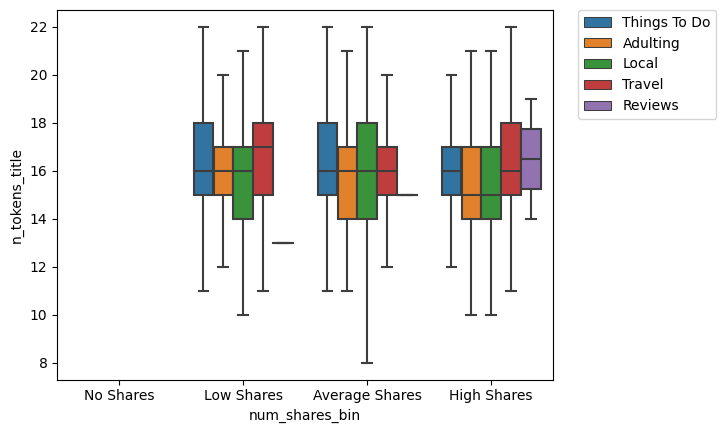

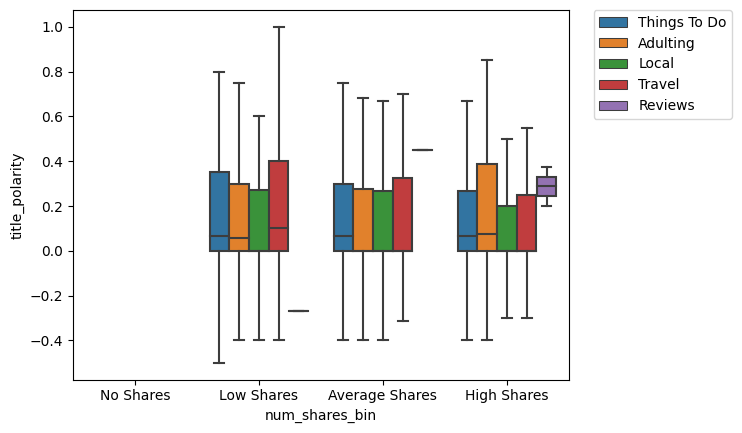

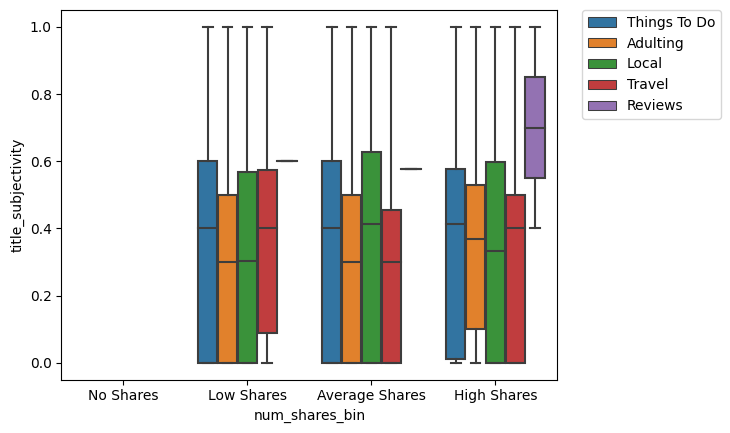

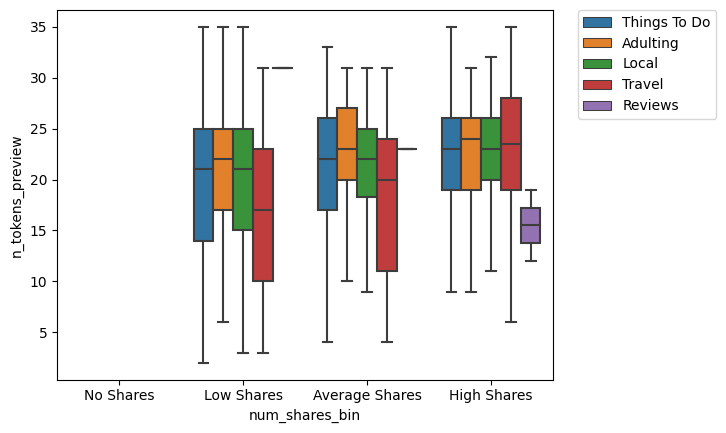

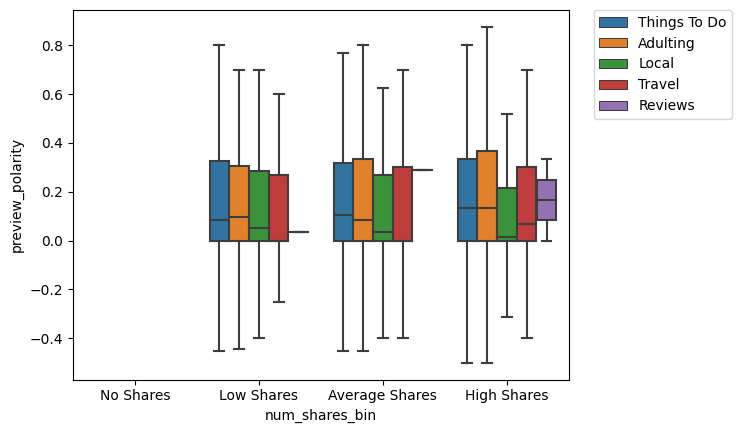

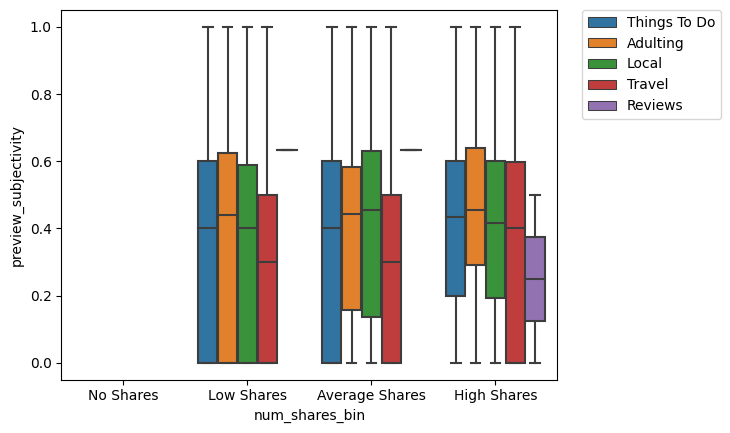

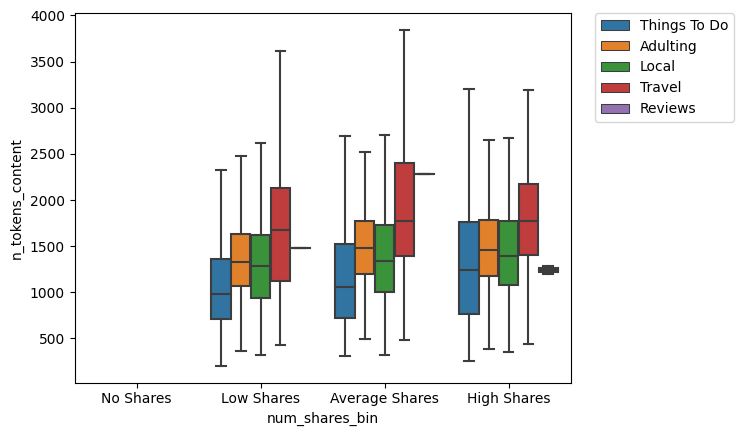

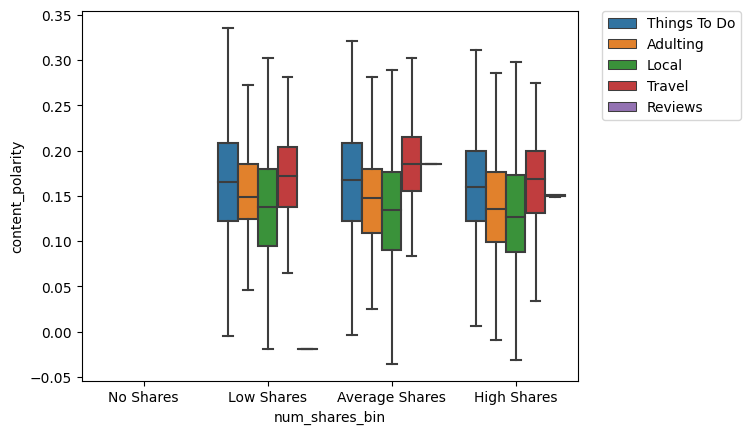

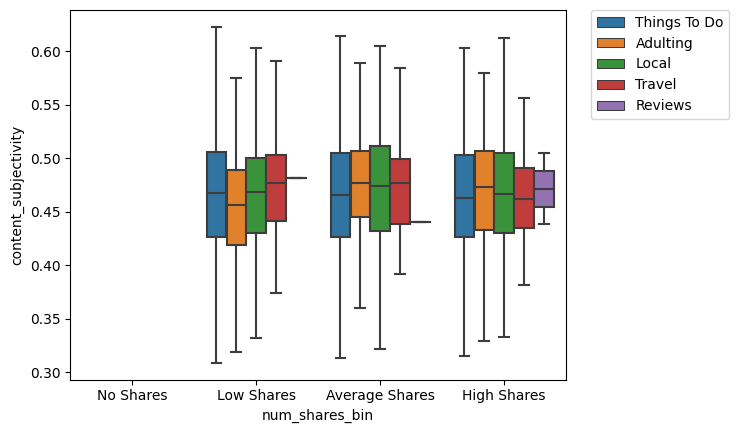

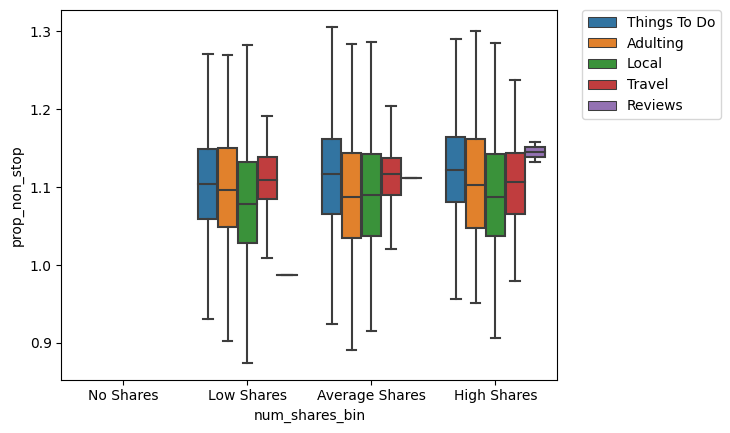

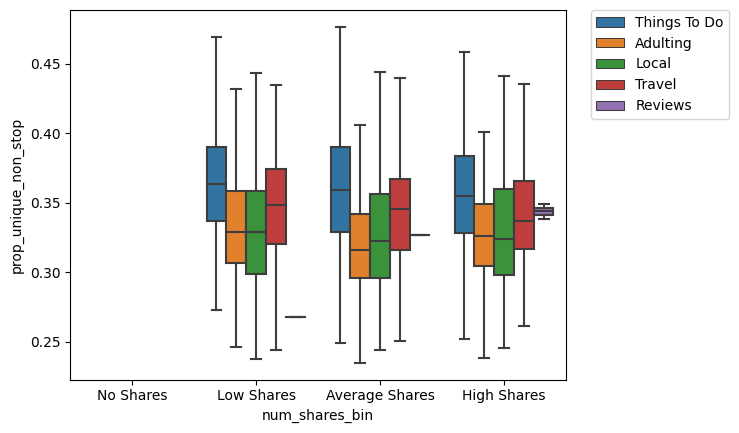

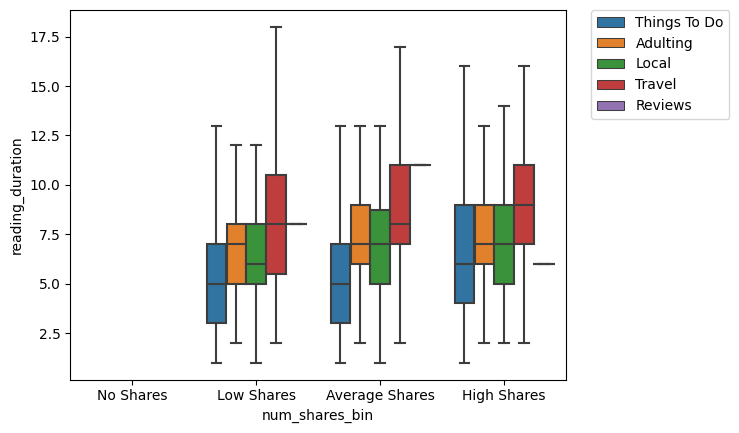

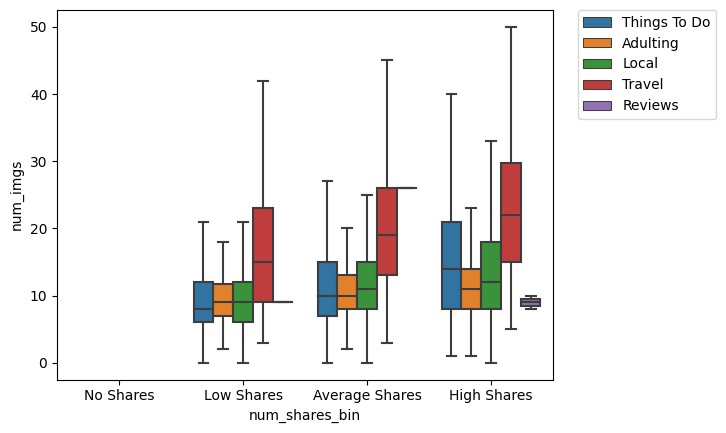

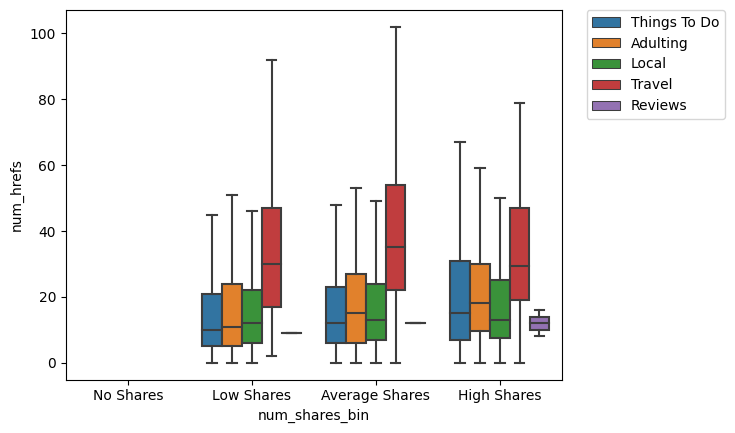

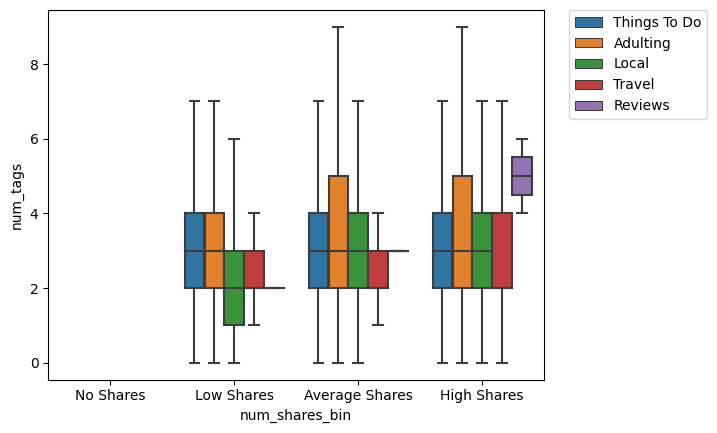

In [ ]:
for v in continuous_cols:
    sns.boxplot(data= df_fe, x='num_shares_bin', y=v, hue='category', 
                order=['No Shares', 'Low Shares', 'Average Shares', 'High Shares'], showfliers=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## Categorical variables

Lets look at the distribution of our categorical variables

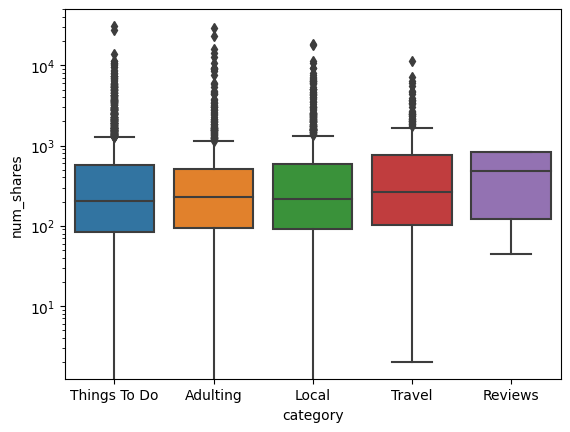

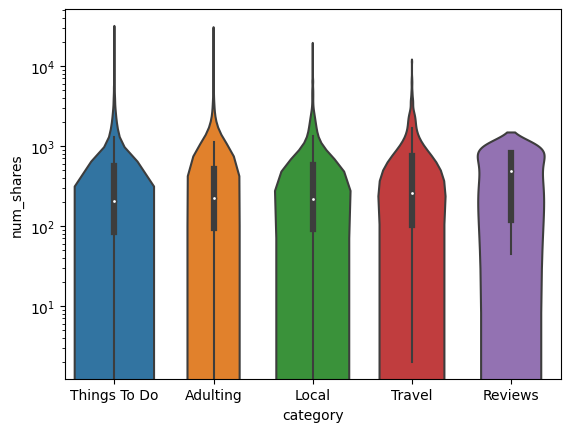

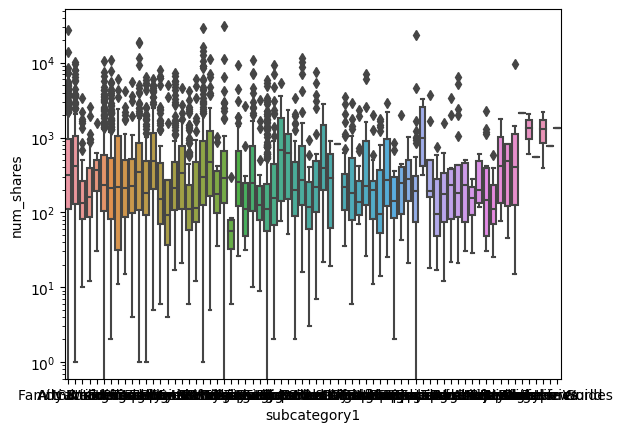

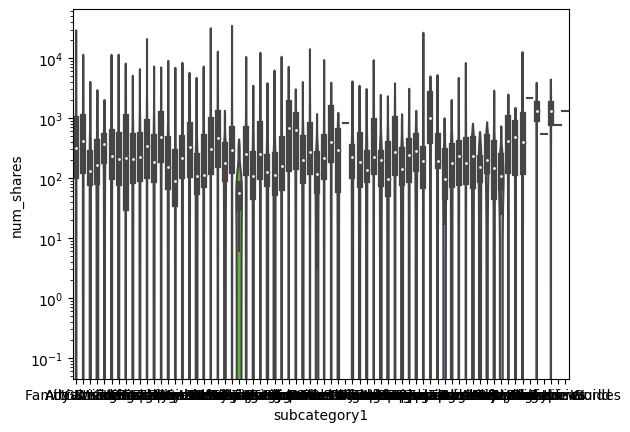

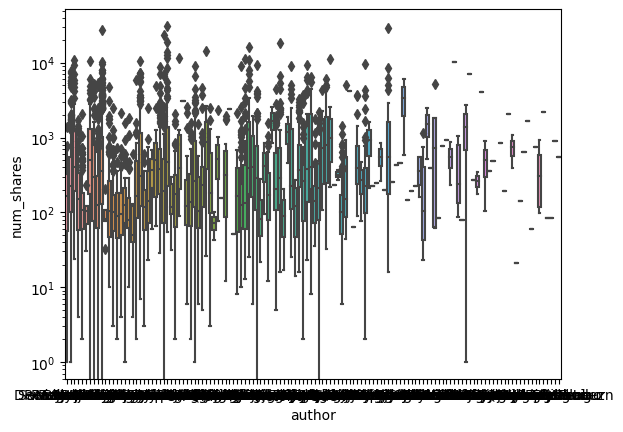

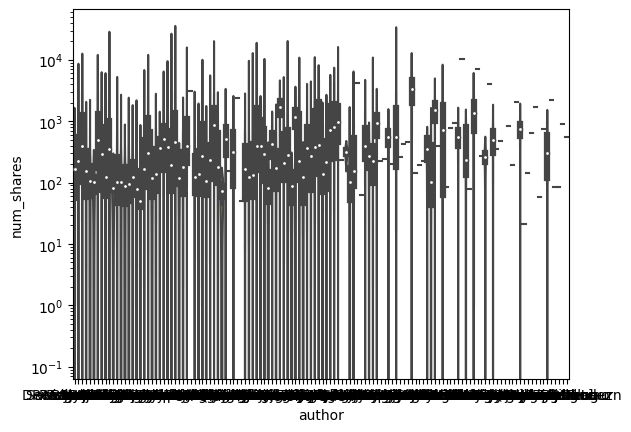

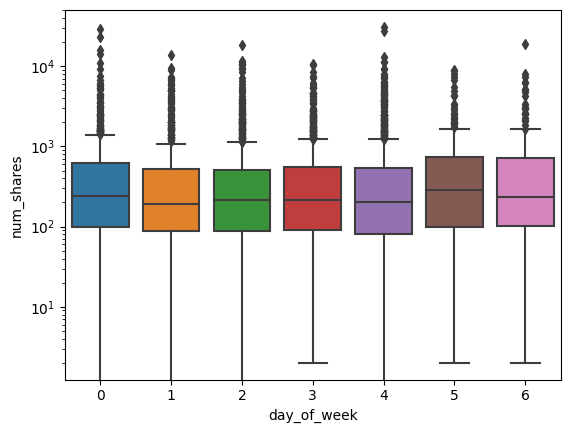

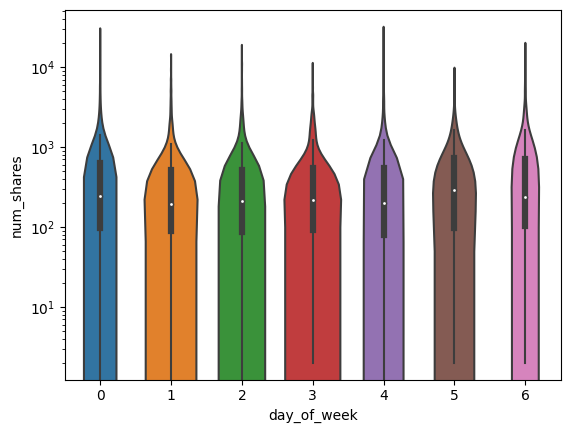

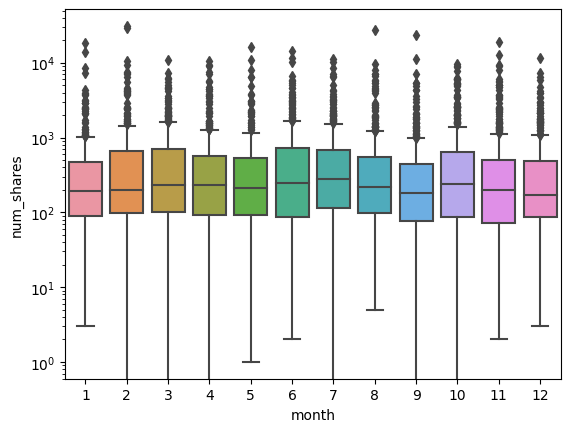

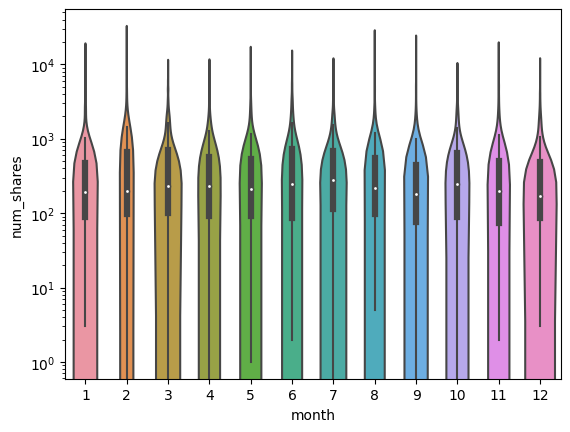

In [ ]:
cat_cols = categorical_cols + target_var
df_cat = df_fe[cat_cols].copy()
for cat_col in df_cat:
    if cat_col != 'num_shares':
        sns.boxplot(x = cat_col, y = 'num_shares', data = df_cat)
        plt.yscale('log')
        plt.show()
        sns.violinplot(x = cat_col, y = 'num_shares', data = df_cat)
        plt.yscale('log')
        plt.show()

Text(0.5, 1.0, 'Number of articles publised by Category')

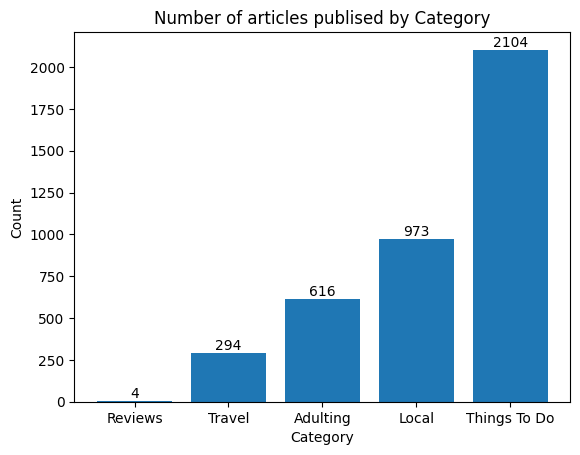

In [ ]:
cat_count = df_cat.groupby(['category']).size().sort_values(ascending = True)

fig, ax = plt.subplots()
bars = ax.bar(cat_count.index, cat_count)
ax.bar_label(bars)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of articles publised by Category')

Lets see if the day of article published has any relation to whether an article is popular or not. 

2 ways to gauge popularity:
- number of shares >= mean
- number of shares >= median

In [ ]:
mean_shares = df_fe['num_shares'].mean()
median_shares = df_fe['num_shares'].median()
df_pop = df_fe.copy()

df_pop['popular_shares_mean'] = df_pop['num_shares'].apply(lambda x: 1 if x >= mean_shares else 0)
df_pop['unpopular_shares_mean'] = df_pop['num_shares'].apply(lambda x: 1 if x < mean_shares else 0)

df_pop['popular_shares_median'] = df_pop['num_shares'].apply(lambda x: 1 if x >= median_shares else 0)
df_pop['unpopular_shares_median'] = df_pop['num_shares'].apply(lambda x: 1 if x < median_shares else 0)

day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# df_pop['day'] = df_pop['day_of_week'].map(day_dict)
pop_unpop = df_pop.groupby(['day_of_week'])[['popular_shares_mean', 'unpopular_shares_mean', 'popular_shares_median', 'unpopular_shares_median']].sum()
pop_unpop['day'] = pop_unpop.index.map(day_dict)

pop_unpop


popular_shares_mean  unpopular_shares_mean  \
day_of_week                                               
0                            134                    436   
1                            132                    505   
2                            142                    548   
3                            146                    532   
4                            202                    765   
5                             75                    212   
6                             42                    120   

             popular_shares_median  unpopular_shares_median        day  
day_of_week                                                             
0                              309                      261     Monday  
1                              297                      340    Tuesday  
2                              345                      345  Wednesday  
3                              344                      334   Thursday  
4                              466                      501     Friday  
5                              159                      128   Saturday  
6                               84                       78     Sunday

<Axes: xlabel='day'>

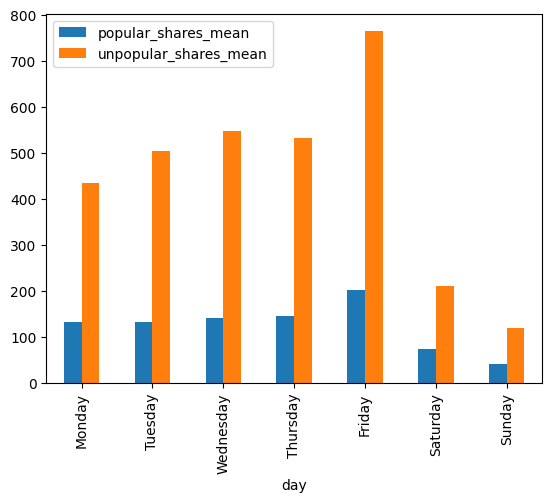

In [ ]:
pop_unpop.plot(x="day", y=["popular_shares_mean", "unpopular_shares_mean"], kind="bar")

<Axes: xlabel='day'>

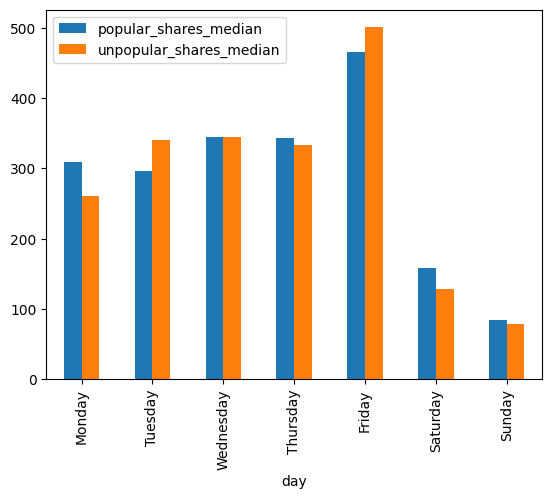

In [ ]:
pop_unpop.plot(x="day", y=["popular_shares_median", "unpopular_shares_median"], kind="bar")

3D scatter plot to check for any clusters between the number of shares, title polarity, and title subjectivity

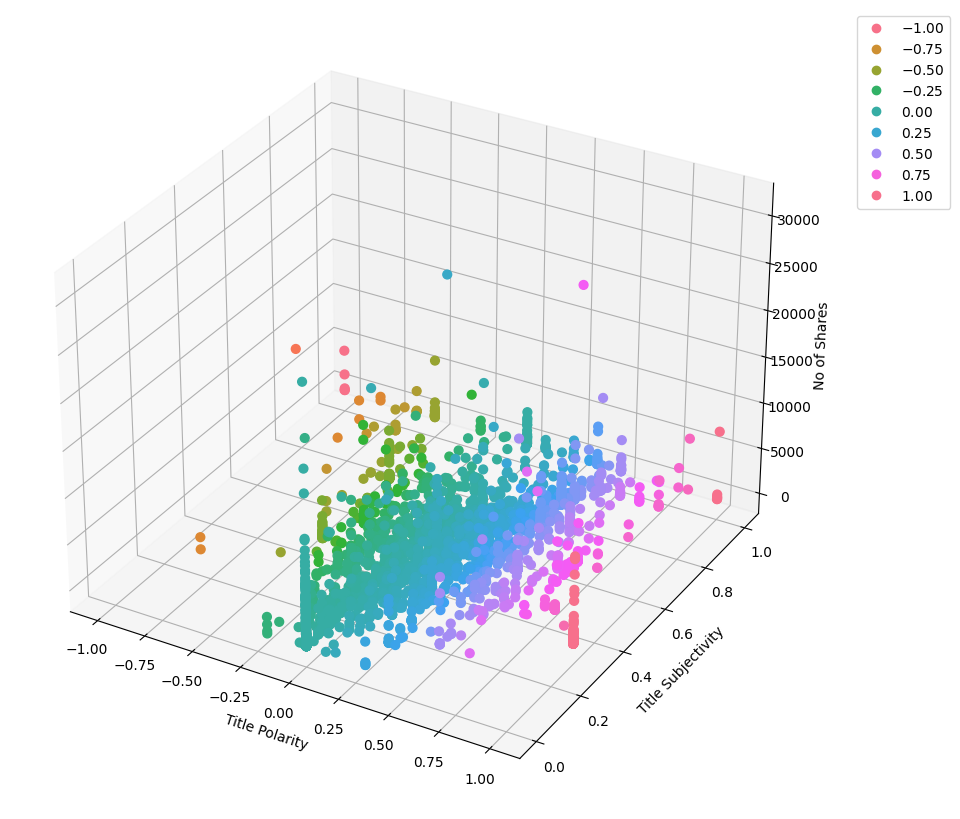

In [ ]:
x = df_fe['title_polarity']
y = df_fe['title_subjectivity']
z = df_fe['num_shares']

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Title Polarity')
ax.set_ylabel('Title Subjectivity')
ax.set_zlabel('No of Shares')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

Comparing top 25 VS bot 25 percentile

In [ ]:
compare_columns = continuous_cols + target_var
df_compare = df_fe[compare_columns].copy()
df_top25 = df_compare[df_compare['num_shares'] >= df_compare['num_shares'].quantile(0.75)].copy()
df_top25.drop(columns = 'num_shares', inplace = True)

df_bot25 = df_compare[df_compare['num_shares'] <= df_compare['num_shares'].quantile(0.25)].copy()
df_bot25.drop(columns = 'num_shares', inplace = True)

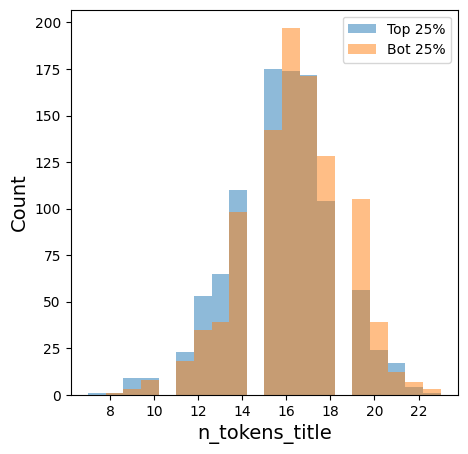

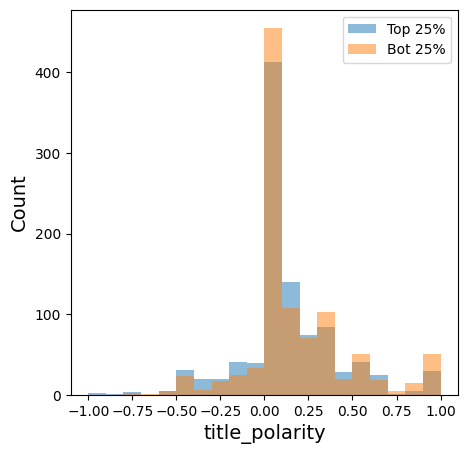

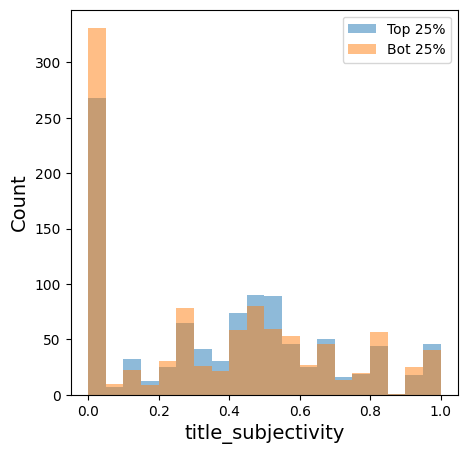

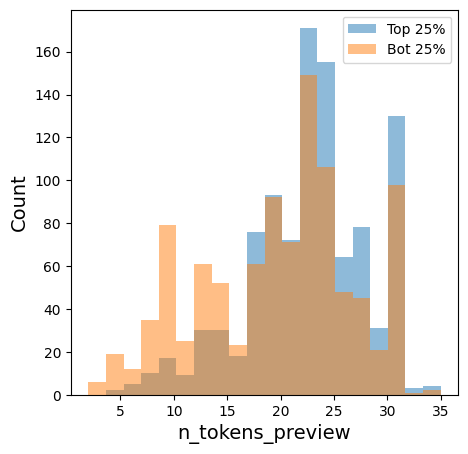

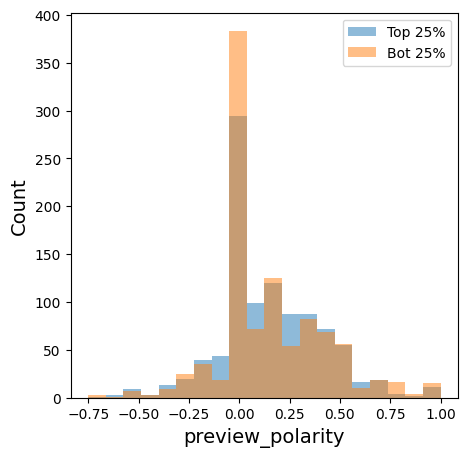

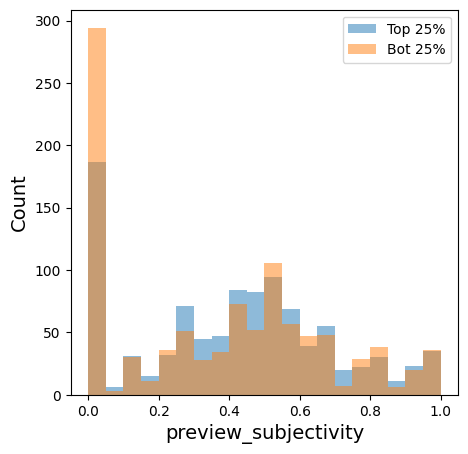

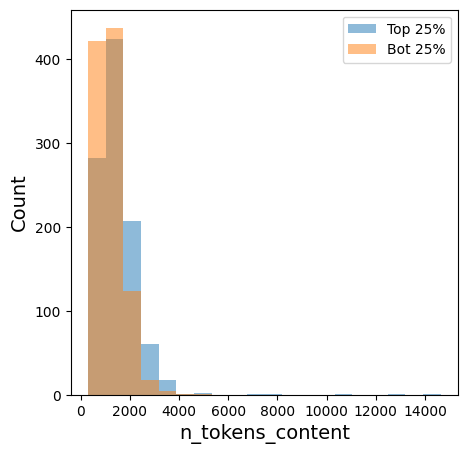

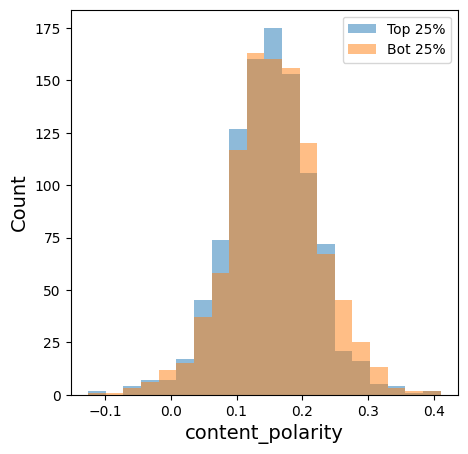

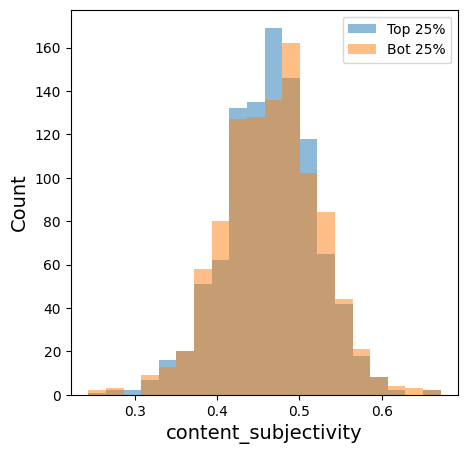

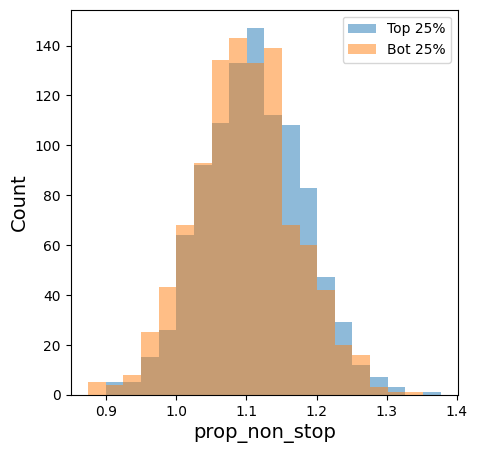

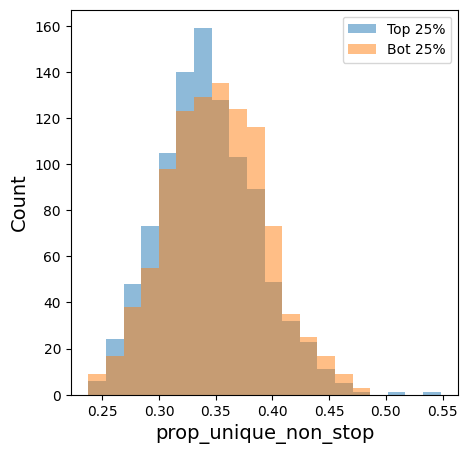

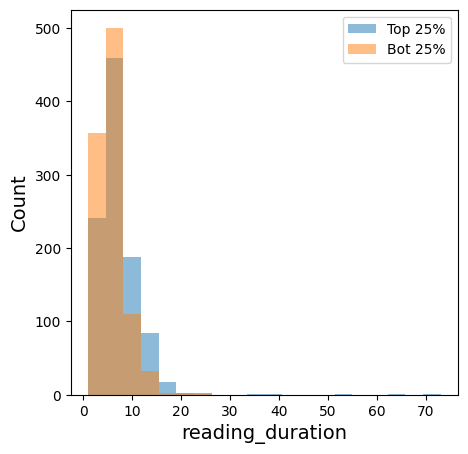

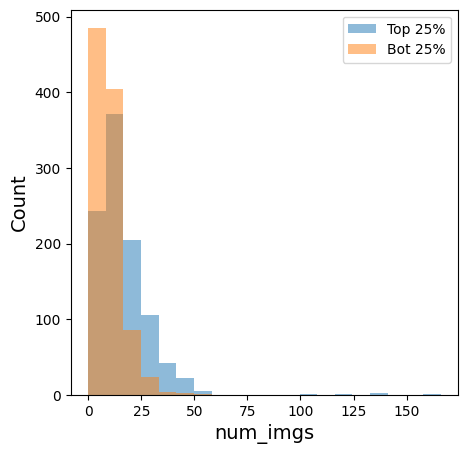

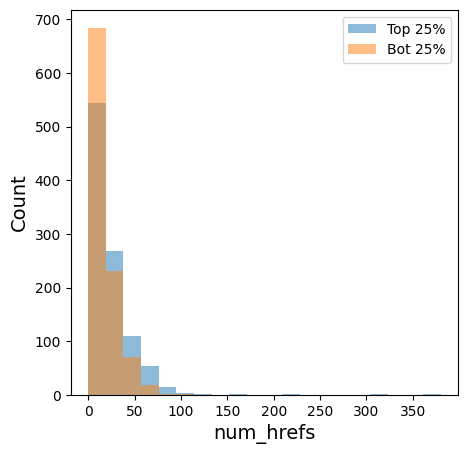

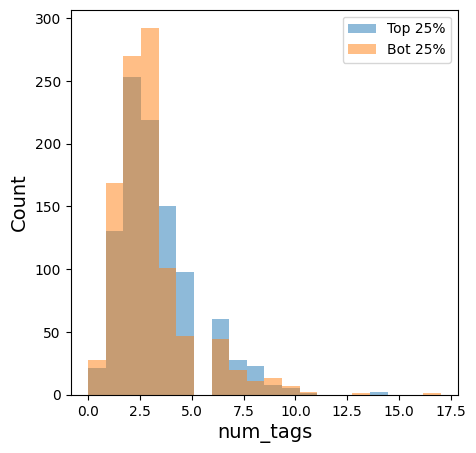

In [ ]:
for i in range(df_top25.shape[1]):
    plt.figure(figsize=(5,5))
    bins=np.histogram(np.hstack((df_bot25.iloc[:,i],df_top25.iloc[:,i])), bins=20)[1] #get the bin edges
    plt.hist(df_top25.iloc[:,i], bins, alpha=0.5, label="Top 25%")
    plt.hist(df_bot25.iloc[:,i], bins, alpha=0.5, label="Bot 25%")
    plt.xlabel(df_top25.columns[i], size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc='upper right')

## KMeans Clustering

In [ ]:
kmeans_cols = continuous_cols + target_var
df_kmeans = df_fe[kmeans_cols].copy()
scaler = StandardScaler()
df_kmeans_scaled = pd.DataFrame(scaler.fit_transform(df_kmeans), columns = df_kmeans.columns)

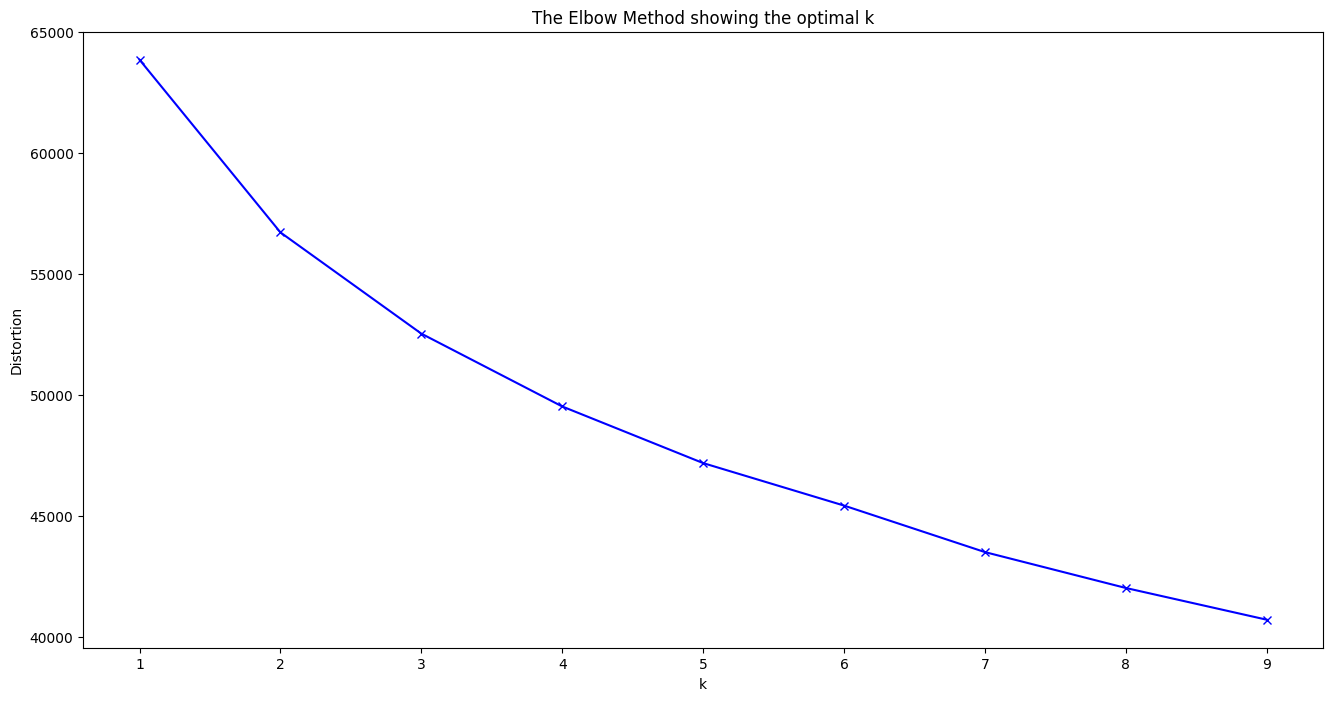

In [ ]:
wcss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 1)
    kmeanModel.fit(df_kmeans_scaled)
    wcss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kl = KneeLocator(range(1, 10), wcss, curve="convex", direction="decreasing")
kl.elbow

4

In [ ]:
kmeanModel = KMeans(n_clusters=3, random_state = 1)
kmeanModel.fit(df_kmeans_scaled)

KMeans(n_clusters=3, random_state=1)

In [ ]:
df_kmeans_scaled['cluster'] = kmeanModel.labels_

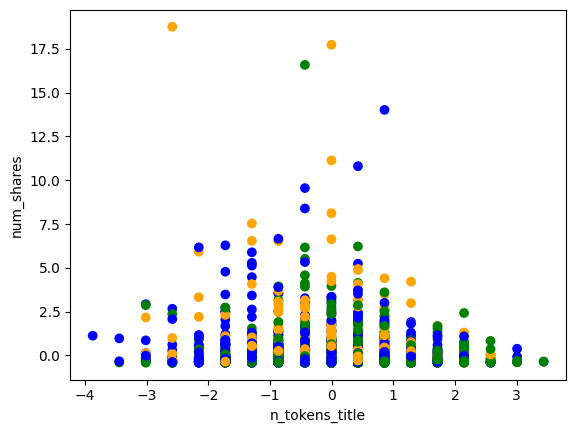

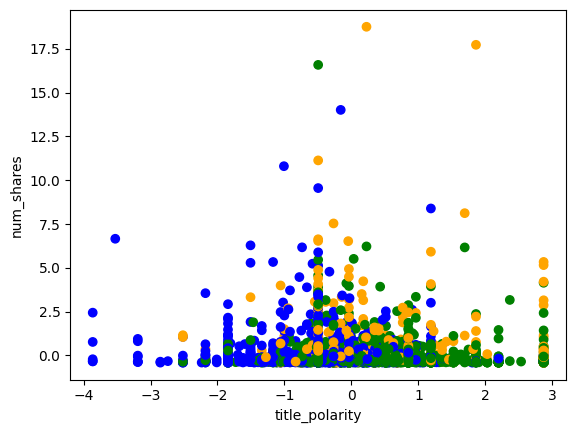

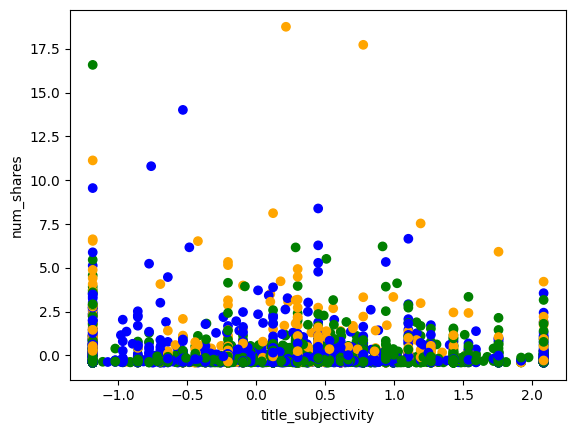

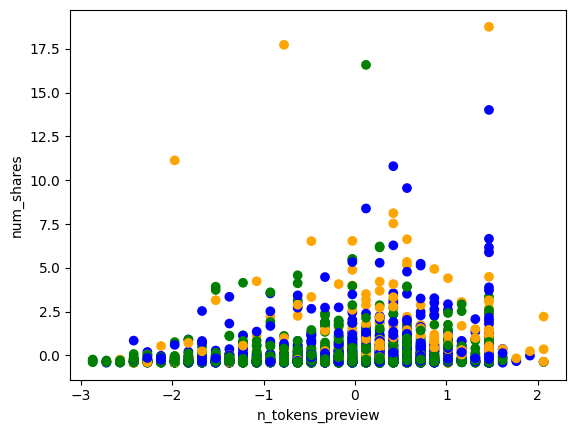

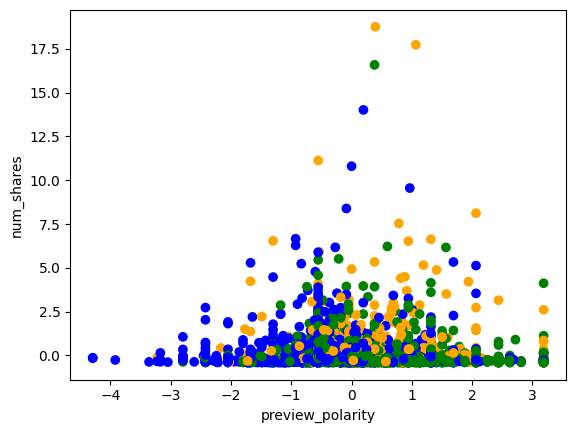

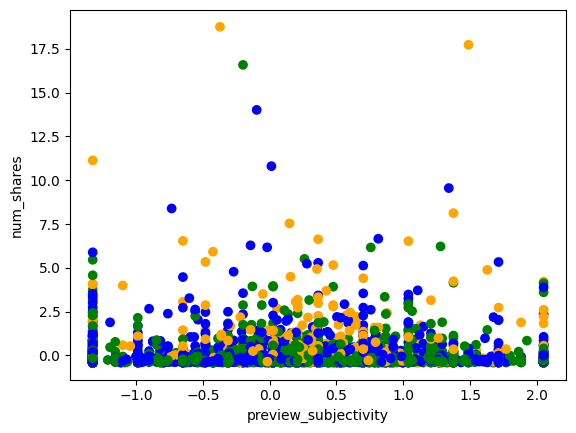

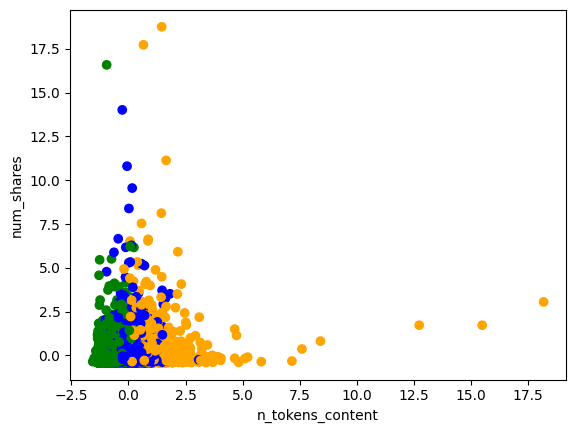

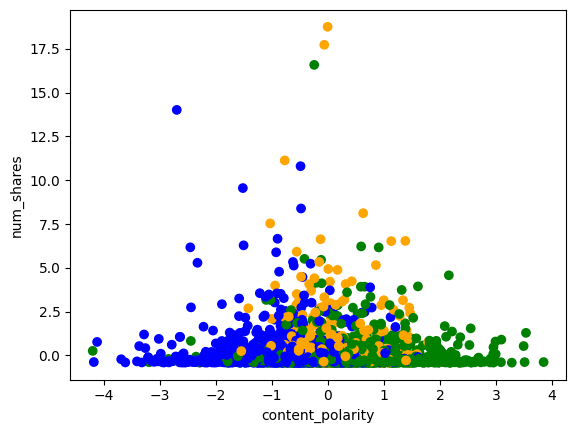

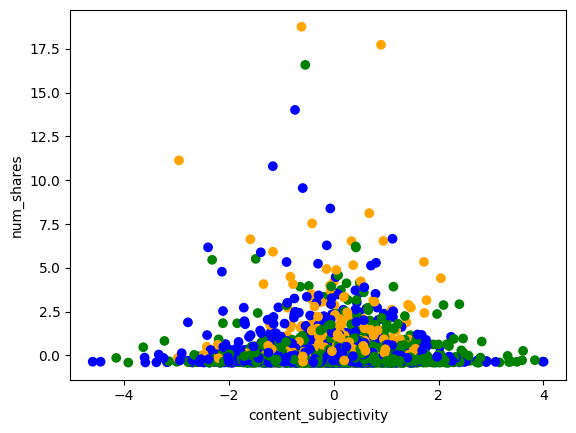

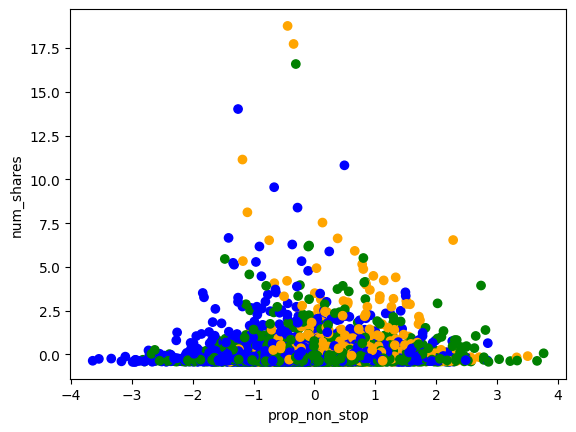

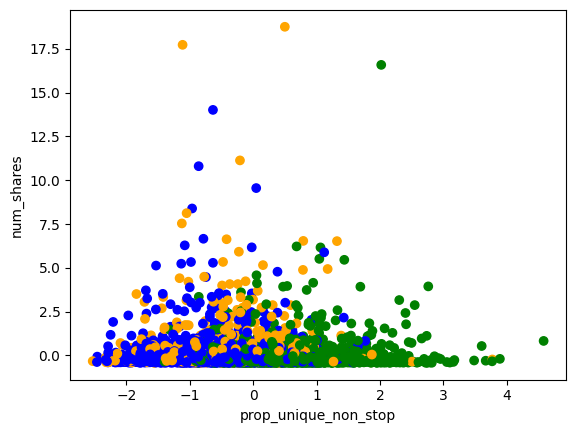

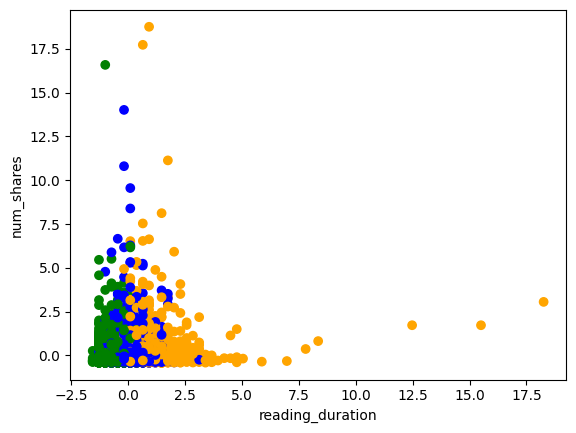

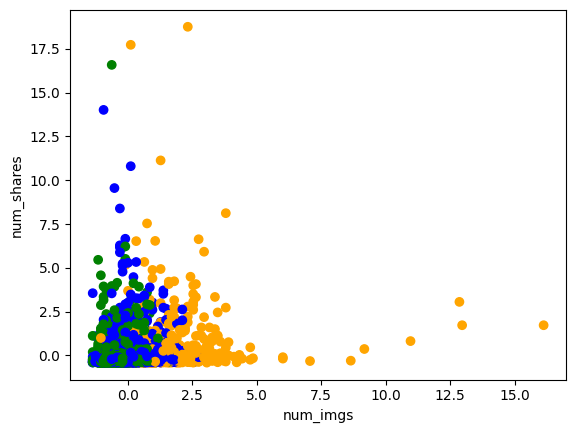

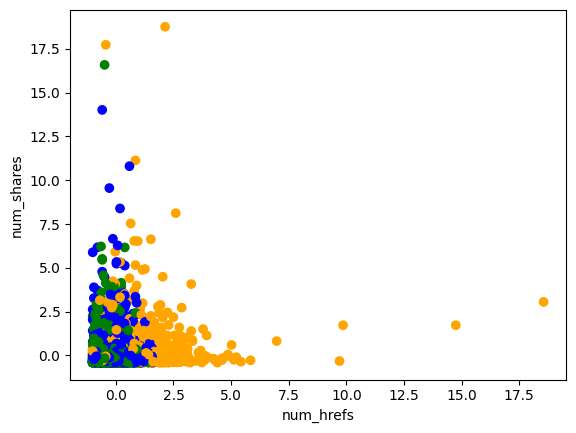

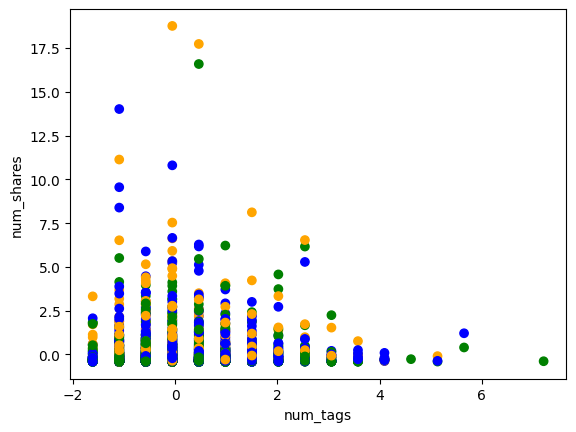

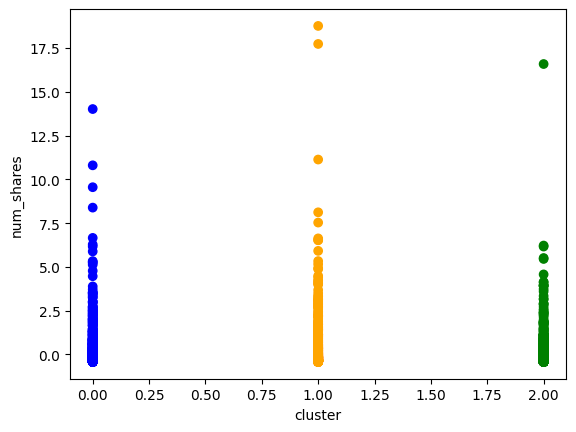

In [ ]:
colors = {0:'blue', 1:'orange', 2:'green', 3:'yellow'}
scattor_cols = df_kmeans_scaled.drop(['num_shares'], axis = 1).copy()

for i in scattor_cols:
    plt.figure()
    plt.scatter(df_kmeans_scaled[i],df_kmeans_scaled['num_shares'], c=df_kmeans_scaled['cluster'].map(colors))
    plt.ylabel('num_shares')
    plt.xlabel(i)
    plt.show()

# Data Preprocessing to Run Models

## Dropping Columns

In [ ]:
df_fe.reset_index(drop=True, inplace=True)

In [ ]:
df_fe.dtypes

url                      object
timedelta                 int64
title                    object
category                 object
subcategory1             object
preview                  object
content                  object
n_tokens_title            int64
title_polarity          float64
title_subjectivity      float64
n_tokens_preview          int64
preview_polarity        float64
preview_subjectivity    float64
n_tokens_content          int64
content_polarity        float64
content_subjectivity    float64
prop_non_stop           float64
prop_unique_non_stop    float64
reading_duration          int64
author                   object
publish_date             object
day_of_week               int64
month                     int64
year                      int64
num_imgs                  int64
num_hrefs                 int64
num_tags                  int64
num_shares                int64
author_category          object
n_tokens_cross            int64
polarity_cross          float64
subjecti

In [ ]:
# checking features
cat = df_fe.select_dtypes(include='O').keys()
# display variabels
cat

Index(['url', 'title', 'category', 'subcategory1', 'preview', 'content',
       'author', 'publish_date', 'author_category', 'num_shares_bin'],
      dtype='object')

In [ ]:
cat_df = df_fe[df_fe.columns.intersection(cat)]
cat_df.head()

url  \
0  https://thesmartlocal.com/read/kampong-gelam-b...   
1        https://thesmartlocal.com/read/headrock-vr/   
2   https://thesmartlocal.com/read/free-steam-games/   
3  https://thesmartlocal.com/read/marina-south-pier/   
4  https://thesmartlocal.com/read/tayo-station-si...   

                                               title      category  \
0  Kampong Gelam Bazaar 2023 Has Light Projection...  Things To Do   
1  HeadRock VR: Virtual Reality Theme Park At Sen...  Things To Do   
2  30 Free Steam Games To Add To Your Library Fro...  Things To Do   
3  Marina South Pier: Ferry Rides To The Southern...  Things To Do   
4  Tayo Station Is A Massive Indoor Playground Wi...  Things To Do   

            subcategory1                                            preview  \
0             Activities  There’s an elevated mezzanine seating area wit...   
1            Attractions  The hyper-realistic virtual skyscraper game se...   
2                 Gaming  Thankfully, not all great games require a port...   
3             Activities  If you’re looking for an outdoor adventure bey...   
4  Family & Kid-friendly  Fans of Tayo The Little Bus, right this way pl...   

                                             content           author  \
0  Follow us on Telegram for the latest updates: ...   Dewi Nurjuwita   
1  Follow us on Telegram for the latest updates: ...      Renae Cheng   
2  Follow us on Telegram for the latest updates: ...       Billy Tran   
3  Follow us on Telegram for the latest updates: ...       Megan Khoe   
4  Follow us on Telegram for the latest updates: ...  Samantha Nguyen   

  publish_date      author_category num_shares_bin  
0   2023-03-21   Less than 50 posts     Low Shares  
1   2023-03-21  More than 200 posts     Low Shares  
2   2023-03-21      50 to 100 posts    High Shares  
3   2023-03-21      50 to 100 posts    High Shares  
4   2023-03-21     100 to 200 posts     Low Shares

In [ ]:
unique_col = ["url", "title", "preview", "content", "publish_date", "author", "num_shares_bin"]
cat_df.drop(unique_col, axis=1, inplace=True)

<ipython-input-73-20160079755f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.drop(unique_col, axis=1, inplace=True)


In [ ]:
cat_df.head()

category           subcategory1      author_category
0  Things To Do             Activities   Less than 50 posts
1  Things To Do            Attractions  More than 200 posts
2  Things To Do                 Gaming      50 to 100 posts
3  Things To Do             Activities      50 to 100 posts
4  Things To Do  Family & Kid-friendly     100 to 200 posts

## One Hot Encoding

In [ ]:
enc = OneHotEncoder().fit(cat_df)
ohe = enc.transform(cat_df).toarray()
enc.get_feature_names_out()

array(['category_Adulting', 'category_Local', 'category_Reviews',
       'category_Things To Do', 'category_Travel',
       'subcategory1_Activities', 'subcategory1_Adulting',
       'subcategory1_America', 'subcategory1_Attractions',
       'subcategory1_Australia', 'subcategory1_Bars & Clubs',
       'subcategory1_Beauty & Wellness', 'subcategory1_Businesses',
       'subcategory1_Career', 'subcategory1_China',
       'subcategory1_Contests', 'subcategory1_Cryptocurrency',
       'subcategory1_Culture', 'subcategory1_Dating & Relationships',
       'subcategory1_Education', 'subcategory1_Europe',
       'subcategory1_Events', 'subcategory1_Family & Kid-friendly',
       'subcategory1_Fashion', 'subcategory1_Finances',
       'subcategory1_Food', 'subcategory1_Food Guides',
       'subcategory1_Food Reviews', 'subcategory1_Gaming',
       'subcategory1_Hacks', 'subcategory1_Heritage', 'subcategory1_Home',
       'subcategory1_Hong Kong', 'subcategory1_Hotel Guides',
       'subcategor

In [ ]:
ohe_df = pd.DataFrame(data=ohe, columns=enc.get_feature_names_out())
ohe_df.head()

category_Adulting  category_Local  category_Reviews  category_Things To Do  \
0                0.0             0.0               0.0                    1.0   
1                0.0             0.0               0.0                    1.0   
2                0.0             0.0               0.0                    1.0   
3                0.0             0.0               0.0                    1.0   
4                0.0             0.0               0.0                    1.0   

   category_Travel  subcategory1_Activities  subcategory1_Adulting  \
0              0.0                      1.0                    0.0   
1              0.0                      0.0                    0.0   
2              0.0                      0.0                    0.0   
3              0.0                      1.0                    0.0   
4              0.0                      0.0                    0.0   

   subcategory1_America  subcategory1_Attractions  subcategory1_Australia  \
0                   0.0                       0.0                     0.0   
1                   0.0                       1.0                     0.0   
2                   0.0                       0.0                     0.0   
3                   0.0                       0.0                     0.0   
4                   0.0                       0.0                     0.0   

   ...  subcategory1_Things To Do In Singapore  subcategory1_Travel  \
0  ...                                     0.0                  0.0   
1  ...                                     0.0                  0.0   
2  ...                                     0.0                  0.0   
3  ...                                     0.0                  0.0   
4  ...                                     0.0                  0.0   

   subcategory1_Travel Guides & Tips  \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   subcategory1_Tutorials & Self-Improvement  subcategory1_Volunteering  \
0                                        0.0                        0.0   
1                                        0.0                        0.0   
2                                        0.0                        0.0   
3                                        0.0                        0.0   
4                                        0.0                        0.0   

   subcategory1_Wedding  author_category_100 to 200 posts  \
0                   0.0                               0.0   
1                   0.0                               0.0   
2                   0.0                               0.0   
3                   0.0                               0.0   
4                   0.0                               1.0   

   author_category_50 to 100 posts  author_category_Less than 50 posts  \
0                              0.0                                 1.0   
1                              0.0                                 0.0   
2                              1.0                                 0.0   
3                              1.0                                 0.0   
4                              0.0                                 0.0   

   author_category_More than 200 posts  
0                                  0.0  
1                                  1.0  
2                                  0.0  
3                                  0.0  
4                                  0.0  

[5 rows x 79 columns]

In [ ]:
# Dropping one column from each category to prevent multicollinearity
to_drop = ["category_Adulting", "subcategory1_Activities", "author_category_Less than 50 posts"]
ohe_df.drop(to_drop, axis=1, inplace=True)

In [ ]:
num_df = df_fe.drop(cat, axis=1)
target_variable = df_fe["num_shares_bin"]
result = pd.concat([num_df,ohe_df,target_variable], axis=1)

# Feature Selection

In [ ]:
# split into train and test set
target_var = "num_shares_bin"
X = result.drop(columns=[target_var], axis=1)
y = result[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

In [ ]:
# Selecting top 20 features
kbest = SelectKBest(f_classif, k=20).fit(X_train, y_train)
pd.DataFrame({'feature': kbest.feature_names_in_, 'score': kbest.scores_}).set_index('feature').squeeze().sort_values(ascending = False)[:20]

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [84] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


feature
num_shares                             500.955527
timedelta                              136.988810
year                                   119.196449
num_imgs                                99.997768
n_tokens_cross                          48.165877
n_tokens_preview                        42.786090
reading_duration                        35.961412
n_tokens_content                        35.207436
num_hrefs                               33.023264
subcategory1_Sales & Promotions         29.950759
subcategory1_Food Guides                23.621475
author_category_100 to 200 posts        23.103997
author_category_More than 200 posts     21.060605
content_cross                           14.947274
subcategory1_Beauty & Wellness          13.472639
subcategory1_Attractions                11.442916
subcategory1_Malaysia                   10.664487
prop_non_stop                            9.614100
n_tokens_title                           9.106535
prop_unique_non_stop                     6

In [ ]:
kbest.get_feature_names_out()

array(['timedelta', 'n_tokens_title', 'n_tokens_preview',
       'n_tokens_content', 'prop_non_stop', 'prop_unique_non_stop',
       'reading_duration', 'year', 'num_imgs', 'num_hrefs', 'num_shares',
       'n_tokens_cross', 'content_cross', 'subcategory1_Attractions',
       'subcategory1_Beauty & Wellness', 'subcategory1_Food Guides',
       'subcategory1_Malaysia', 'subcategory1_Sales & Promotions',
       'author_category_100 to 200 posts',
       'author_category_More than 200 posts'], dtype=object)

In [ ]:
result_fs = result[result.columns.intersection(kbest.get_feature_names_out())]
result_fs = pd.concat([result_fs, target_variable], axis=1)

In [ ]:
result_fs.drop(columns='num_shares', inplace=True)
result_fs.to_csv(f'/content/drive/My Drive/IS4242/datasets/smartlocal_fe.csv', index=False)

# Text Embedding
Text embedding is a process of representing text data in a numerical vector format that can be used as input for machine learning models. To create text embeddings, the same preprocessing steps as Polarity and Subjectivity were used with the additional of Uniform Manifold Approximation and Projection (UMAP) for dimensionality reduction. Below are the different text embeddings models used:
- Word2Vec (SkipGram, CBOW)
- Doc2Vec
- TF-IDF
- BERT


## BERT

In [ ]:
# # run text data through pretrained BERT model
# # warning: takes 1 to 2 hours to run

# # select pretrained BERT text embedding model
# BERT_embedder = SentenceTransformer('all-mpnet-base-v2')

# text_data = {
#     'title': title_processed,
#     'preview': preview_processed,
#     'content': content_processed,
# }

# for name, text in text_data.items():
#     embeddings = BERT_embedder.encode(list(text))
#     embeddings_df = pd.DataFrame(embeddings)
#     embeddings_df.to_csv(f'datasets/{name}_embeddings_BERT.csv', index=False)

In [ ]:
# # load text embedding and run it through UMAP at suitable
# title_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/title_embeddings_BERT.csv'))
# preview_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/preview_embeddings_BERT.csv'))
# content_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/content_embeddings_BERT.csv'))

## Word2Vec

In [ ]:
def avg_word2vec(model, model_vocabs, tokenized_sentences, size):
  list_of_wv = [[model.wv[token] for token in sentence if token in model_vocabs] for sentence in tokenized_sentences]
  list_of_avg_wv = []
  for wvs in list_of_wv:
    wvs = np.array(wvs)
    if len(wvs) > 0:
      list_of_avg_wv.append(wvs.mean(axis=0))
    else:
      list_of_avg_wv.append(np.zeros(size, dtype=float))
  return  np.array(list_of_avg_wv)

In [ ]:
# select pretrained skipgram word2vec text embedding model
skip_gram_model = Word2Vec(X_train, sg=1, min_count=1)
skipgram_wordpool = set(skip_gram_model.wv.index_to_key)

In [ ]:
text_data = {
    'title': title_processed, 
    'preview': preview_processed, 
    'content': content_processed, 
}

for name, df in text_data.items():
  embeddings = avg_word2vec(skip_gram_model, skipgram_wordpool, df, 100)
  embeddings_df = pd.DataFrame(embeddings)

  path = f'/content/drive/My Drive/IS4242/datasets/{name}_embeddings_word2vec.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    embeddings_df.to_csv(f)

In [ ]:
# load text embedding and run it through UMAP at suitable
title_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/title_embeddings_word2vec.csv'))
preview_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/preview_embeddings_word2vec.csv'))
content_embeddings_df = umap.UMAP(n_components=10).fit_transform(pd.read_csv('./drive/MyDrive/IS4242/datasets/content_embeddings_word2vec.csv'))

In [ ]:
title_embeddings_df.shape

(3991, 10)

In [ ]:
# Combine text embedding and dataset after feature selection
final = pd.concat([result_fs, pd.DataFrame(title_embeddings_df), pd.DataFrame(preview_embeddings_df), pd.DataFrame(content_embeddings_df)], axis=1)

# split into train and test set
# using the same random state hence no data leakage
target_var = "num_shares_bin"
X = final.drop(columns=[target_var], axis=1)
y = final[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

# Final Dataset

In [ ]:
X_train.head()

timedelta  n_tokens_title  n_tokens_preview  n_tokens_content  \
927         278              16                27              2421   
1653        504              18                26              1517   
926         278              15                17               471   
2046        624              14                19              1790   
124          33              18                 5              1548   

      prop_non_stop  reading_duration  year  num_imgs  num_hrefs  \
927        1.173895                12  2022        17         49   
1653       1.183256                 7  2021        17         39   
926        1.208068                 2  2022         4         10   
2046       1.175419                 9  2021        14         42   
124        1.113049                 8  2023        23         36   

      n_tokens_cross  ...          0          1         2         3         4  \
927          1045872  ...   9.210218   4.488758  9.759254 -1.036698  1.663106   
1653          709956  ...   6.005623  -0.810776  8.361201  9.484282  8.929991   
926           120105  ...   9.216924   4.497062  9.706679 -1.071680  1.637418   
2046          476140  ...   4.216797  -0.716214  3.030584  9.637932  1.927097   
124           139320  ...  11.071860  10.656751  0.323478  9.637359  8.138059   

             5          6          7          8         9  
927   3.661886   0.544962  10.650157   2.339772  3.383864  
1653  8.138627  10.237036   5.871613  -0.032919  6.157640  
926   3.742363   0.609557  10.707780   2.245502  3.492724  
2046  8.671865   0.557113   7.507898  10.091745  3.643471  
124   2.814136   3.667874   5.159792   4.939991  3.889118  

[5 rows x 50 columns]

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3192, 50)
(799, 50)
(3192,)
(799,)


In [ ]:
# export
# warning: takes 1 to 2 hours to run
final_files = {
    'X_train': X_train, 
    'X_test': X_test, 
    'y_train': y_train,
    'y_test': y_test 
}

for name, df in final_files.items():
    path = f'/content/drive/My Drive/IS4242/datasets/{name}.csv'
    with open(path, 'w', encoding = 'utf-8-sig') as f:
        df.to_csv(f)